In [6]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [8]:
#average scores flows link 1

MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        Y = df[df.columns[64]]
        X = df.drop(columns=['link_1_flow'])
        X['link_1_flow'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 4.2262262918320435
RMSE: 5.560
R^2: 1.000
[['node_26_demand', 'node_4_pressure', 'link_4_flow', 'node_19_demand', 'node_20_demand']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 3.0228850673200407
RMSE: 4.008
R^2: 1.000
[['node_31_pressure', 'link_6_flow', 'link_17_flow', 'link_8_flow', 'node_21_demand']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 4.633197009461384
RMSE: 6.161
R^2: 1.000
[['node_16_pressure', 'node_27_pressure', 'node_20_pressure', 'link_10_flow', 'node_26_demand']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 3.030508157565986
RMSE: 4.009
R^2: 1.000
[['node_1_demand', 'link_28_flow', 'node_11_demand', 'node_22_pressure', 'link_15_flow']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 4.689444454418475
RMSE: 6.131
R^2: 1.000
[['link_25_flow', 'node_16_demand', 'link_31_flow', 'link_15_flow', 'node_23_demand']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 4.579561537941026
RMSE: 6.096
R^2: 1.000
[['node_12_demand', 'link_6_flow', 'node_26_pressure', 'node_3_demand', 'link_15_flow']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 3.9880327588809723
RMSE: 5.250
R^2: 1.000
[['node_14_pressure', 'link_3_flow', 'link_7_flow', 'node_7_demand', 'link_12_flow']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 4.810772857502723
RMSE: 6.381
R^2: 1.000
[['link_3_flow', 'node_20_demand', 'node_10_demand', 'node_30_demand']]
starting df shape: (87600, 92)
This is training run 8 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 8 Mean Absolute Error: 2.6103840211237936
RMSE: 3.517
R^2: 1.000
[['node_21_demand', 'node_15_pressure', 'node_21_pressure', 'node_11_demand', 'link_16_flow']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 3.0288455068167037
RMSE: 4.009
R^2: 1.000
[['node_20_pressure', 'link_9_flow', 'node_29_demand', 'node_20_demand', 'node_9_demand']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 3.0374989129582577
RMSE: 4.033
R^2: 1.000
[['link_32_flow', 'node_29_pressure', 'node_9_pressure', 'node_29_demand', 'node_1_pressure', 'node_23_demand', 'node_3_pressure', 'node_1_demand', 'node_23_pressure', 'link_20_flow']]
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 4.01318316882605
RMSE: 5.242
R^2: 1.000
[['link_9_flow', 'node_21_pressure', 'link_14_flow', 'link_5_flow', 'node_30_pressure', 'node_10_demand', 'node_16_demand', 'node_4_demand', 'node_1_demand', 'node_29_pressure']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 4.393937624149944
RMSE: 5.793
R^2: 1.000
[['node_6_pressure', 'link_10_flow', 'link_9_flow', 'node_24_pressure', 'node_28_pressure', 'node_29_demand', 'link_4_flow', 'node_18_pressure', 'link_2_flow', 'node_7_pressure']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 5.624963877735886
RMSE: 7.368
R^2: 1.000
[['node_12_demand', 'node_31_pressure', 'node_4_pressure', 'node_5_demand', 'node_26_demand', 'node_9_pressure', 'node_21_demand', 'node_20_demand', 'link_19_flow', 'node_27_demand']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 3.2494487720891385
RMSE: 4.365
R^2: 1.000
[['node_5_demand', 'node_14_demand', 'node_25_demand', 'link_11_flow', 'node_22_demand', 'node_17_demand', 'link_31_flow', 'link_7_flow', 'node_15_pressure']]
starting df shape: (87600, 87)
This is training run 5 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 5 Mean Absolute Error: 2.6910046630118107
RMSE: 3.565
R^2: 1.000
[['node_19_demand', 'reservoir_pressure', 'link_9_flow', 'link_17_flow', 'node_24_demand', 'node_19_pressure', 'node_8_demand', 'node_23_demand', 'link_24_flow', 'node_12_pressure']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 4.031663697439517
RMSE: 5.298
R^2: 1.000
[['node_18_pressure', 'node_12_demand', 'node_17_demand', 'node_11_demand', 'node_30_pressure', 'link_3_flow', 'node_7_pressure', 'link_29_flow', 'node_9_demand', 'node_7_demand']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 3.455907382622178
RMSE: 4.553
R^2: 1.000
[['link_27_flow', 'link_17_flow', 'node_22_pressure', 'node_17_demand', 'node_13_pressure', 'node_12_demand', 'node_27_demand', 'link_7_flow', 'node_12_pressure', 'node_16_pressure']]
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 3.990600573432776
RMSE: 5.270
R^2: 1.000
[['node_29_pressure', 'node_30_demand', 'node_30_pressure', 'node_1_demand', 'link_21_flow', 'link_30_flow', 'node_6_pressure', 'node_21_pressure', 'link_16_flow', 'node_19_pressure']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 4.382772289804416
RMSE: 5.758
R^2: 1.000
[['link_3_flow', 'link_21_flow', 'node_12_pressure', 'link_2_flow', 'node_13_pressure', 'node_8_pressure', 'node_13_demand', 'node_9_demand', 'link_28_flow', 'link_31_flow']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 5.414628744611192
RMSE: 6.984
R^2: 1.000
[['node_4_demand', 'node_10_pressure', 'node_29_pressure', 'node_26_pressure', 'link_15_flow', 'node_17_demand', 'node_8_pressure', 'link_19_flow', 'node_29_demand', 'node_30_demand', 'node_21_demand', 'node_15_demand', 'node_22_pressure', 'node_28_demand', 'node_9_pressure']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 5.31785321287913
RMSE: 7.106
R^2: 1.000
[['node_23_demand', 'node_30_pressure', 'node_3_demand', 'node_20_demand', 'node_20_pressure', 'node_29_demand', 'node_15_demand', 'link_32_flow', 'link_17_flow', 'node_6_pressure', 'link_12_flow', 'node_2_demand', 'node_24_demand', 'node_5_demand']]
starting df shape: (87600, 82)
This is training run 2 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 2 Mean Absolute Error: 2.5531619266288033
RMSE: 3.401
R^2: 1.000
[['node_23_pressure', 'node_14_pressure', 'node_16_pressure', 'node_6_demand', 'link_17_flow', 'link_25_flow', 'node_8_pressure', 'link_14_flow', 'link_20_flow', 'link_18_flow', 'link_9_flow', 'node_6_pressure', 'node_12_pressure', 'node_18_demand', 'link_12_flow']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 5.448385597287791
RMSE: 7.128
R^2: 1.000
[['link_16_flow', 'link_24_flow', 'link_31_flow', 'node_6_demand', 'node_9_pressure', 'node_26_demand', 'reservoir_pressure', 'node_10_pressure', 'node_7_pressure', 'node_1_pressure', 'node_2_pressure', 'link_3_flow', 'node_27_pressure', 'node_1_demand', 'link_21_flow']]
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 3.8341064920409043
RMSE: 5.040
R^2: 1.000
[['node_19_demand', 'reservoir_demand', 'node_24_demand', 'node_5_demand', 'node_20_pressure', 'link_19_flow', 'node_18_demand', 'node_9_pressure', 'node_31_demand', 'link_26_flow', 'node_2_demand', 'node_7_pressure', 'node_3_demand', 'link_20_flow', 'link_21_flow']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 0.579908049313876
RMSE: 0.758
R^2: 1.000
[['node_13_demand', 'link_32_flow', 'node_7_pressure', 'node_24_pressure', 'link_9_flow', 'node_17_demand', 'node_5_pressure', 'link_26_flow', 'node_30_demand', 'link_23_flow', 'node_2_demand', 'node_17_pressure', 'node_1_pressure', 'node_26_demand', 'node_8_demand']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 4.6924171033624065
RMSE: 6.189
R^2: 1.000
[['link_27_flow', 'node_30_pressure', 'link_25_flow', 'node_25_pressure', 'node_13_pressure', 'node_2_pressure', 'node_25_demand', 'node_13_demand', 'node_20_demand', 'link_13_flow', 'node_8_pressure', 'link_4_flow', 'link_17_flow', 'node_26_demand', 'node_15_demand']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 2.8862400831914914
RMSE: 3.869
R^2: 1.000
[['node_16_pressure', 'link_9_flow', 'node_25_pressure', 'reservoir_pressure', 'link_26_flow', 'link_11_flow', 'node_6_demand', 'node_22_pressure', 'node_6_pressure', 'node_9_demand', 'link_10_flow', 'link_8_flow', 'link_16_flow', 'link_12_flow', 'node_22_demand']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 5.845478421082237
RMSE: 7.633
R^2: 1.000
[['node_1_pressure', 'node_28_demand', 'node_2_pressure', 'node_24_demand', 'node_18_pressure', 'node_10_pressure', 'link_16_flow', 'node_25_pressure', 'node_21_pressure', 'link_17_flow', 'link_2_flow', 'link_27_flow', 'link_23_flow', 'node_14_demand', 'node_13_demand']]
starting df shape: (87600, 81)
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 9 Mean Absolute Error: 5.667977081610724
RMSE: 7.413
R^2: 1.000
[['node_24_demand', 'link_30_flow', 'node_25_demand', 'link_12_flow', 'node_30_pressure', 'node_27_demand', 'node_16_pressure', 'node_19_demand', 'link_10_flow', 'reservoir_demand', 'node_15_demand', 'link_3_flow', 'link_31_flow', 'link_28_flow', 'node_17_pressure']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 0.28122026334749745
RMSE: 0.369
R^2: 1.000
[['reservoir_demand', 'link_32_flow', 'node_8_pressure', 'node_26_pressure', 'node_19_pressure', 'node_15_demand', 'link_12_flow', 'link_3_flow', 'link_29_flow', 'node_17_demand', 'node_22_demand', 'link_20_flow', 'link_16_flow', 'node_31_demand', 'node_11_demand', 'reservoir_pressure', 'node_27_demand', 'link_13_flow', 'node_2_pressure']]
starting df shape: (87600, 77)
This is training run 1 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 1 Mean Absolute Error: 0.37183111401639435
RMSE: 0.482
R^2: 1.000
[['reservoir_demand', 'node_18_demand', 'node_10_demand', 'node_7_pressure', 'link_24_flow', 'link_2_flow', 'link_13_flow', 'node_10_pressure', 'node_23_demand', 'link_17_flow', 'node_12_demand', 'node_3_pressure', 'node_11_demand', 'node_1_demand', 'link_16_flow', 'node_16_pressure', 'node_8_demand', 'link_30_flow', 'link_22_flow']]
starting df shape: (87600, 77)
This is training run 2 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 2 Mean Absolute Error: 0.8809902215427566
RMSE: 1.138
R^2: 1.000
[['node_2_pressure', 'reservoir_pressure', 'node_11_demand', 'node_28_pressure', 'link_3_flow', 'link_10_flow', 'link_18_flow', 'node_11_pressure', 'node_2_demand', 'node_15_demand', 'link_26_flow', 'link_29_flow', 'node_3_pressure', 'link_6_flow', 'node_10_pressure', 'link_9_flow', 'node_18_demand', 'node_5_pressure', 'link_11_flow']]
starting df shape: (87600, 77)
This is training run 3 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 3 Mean Absolute Error: 4.23860377972665
RMSE: 5.536
R^2: 1.000
[['link_3_flow', 'node_5_pressure', 'node_24_pressure', 'node_17_pressure', 'node_14_pressure', 'node_25_pressure', 'node_11_demand', 'link_13_flow', 'node_19_demand', 'node_18_pressure', 'link_11_flow', 'node_29_pressure', 'link_10_flow', 'link_5_flow', 'node_26_demand', 'node_3_pressure', 'node_15_demand', 'link_12_flow', 'node_16_demand', 'node_20_demand']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 3.299838282282221
RMSE: 4.383
R^2: 1.000
[['node_15_pressure', 'node_13_pressure', 'link_20_flow', 'link_9_flow', 'link_30_flow', 'node_30_pressure', 'node_21_demand', 'node_29_demand', 'link_17_flow', 'node_1_demand', 'link_32_flow', 'node_22_demand', 'node_18_pressure', 'node_23_pressure', 'node_6_pressure', 'link_16_flow', 'node_4_demand', 'node_24_demand', 'node_17_demand', 'node_5_pressure']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 5.065300630600481
RMSE: 6.601
R^2: 1.000
[['node_30_pressure', 'link_27_flow', 'node_15_pressure', 'node_20_pressure', 'node_12_pressure', 'link_22_flow', 'link_15_flow', 'node_22_demand', 'node_9_pressure', 'node_21_demand', 'node_9_demand', 'link_26_flow', 'link_20_flow', 'node_21_pressure', 'node_2_demand', 'link_24_flow', 'node_26_pressure', 'node_5_pressure', 'link_19_flow', 'node_14_pressure']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 3.063949657760255
RMSE: 4.105
R^2: 1.000
[['node_11_pressure', 'node_21_pressure', 'node_6_pressure', 'link_22_flow', 'node_2_demand', 'node_9_pressure', 'node_9_demand', 'node_5_pressure', 'node_4_pressure', 'node_6_demand', 'node_16_pressure', 'node_17_demand', 'node_15_demand', 'node_28_pressure', 'node_8_demand', 'node_19_demand', 'link_2_flow', 'node_27_pressure', 'link_17_flow', 'link_29_flow']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 8.000565991707857
RMSE: 10.426
R^2: 1.000
[['node_16_pressure', 'node_31_pressure', 'link_31_flow', 'link_7_flow', 'node_13_demand', 'node_3_pressure', 'node_19_demand', 'node_5_demand', 'link_19_flow', 'link_25_flow', 'node_10_pressure', 'link_22_flow', 'node_24_pressure', 'node_6_demand', 'node_19_pressure', 'node_12_pressure', 'link_9_flow', 'node_23_pressure', 'link_5_flow', 'link_26_flow']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 3.146514942788911
RMSE: 4.220
R^2: 1.000
[['link_20_flow', 'node_27_pressure', 'node_16_pressure', 'node_23_pressure', 'link_23_flow', 'node_20_pressure', 'node_27_demand', 'node_4_demand', 'node_11_pressure', 'node_31_demand', 'link_8_flow', 'node_10_pressure', 'link_3_flow', 'node_30_demand', 'link_22_flow', 'node_6_pressure', 'node_5_demand', 'node_19_pressure', 'node_9_pressure', 'node_12_demand']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 3.9992607416314647
RMSE: 5.270
R^2: 1.000
[['link_9_flow', 'node_27_pressure', 'node_29_demand', 'node_18_demand', 'node_20_pressure', 'node_7_demand', 'node_14_demand', 'link_22_flow', 'node_26_pressure', 'node_10_demand', 'node_3_demand', 'link_27_flow', 'node_28_pressure', 'node_9_demand', 'node_21_pressure', 'link_18_flow', 'link_14_flow', 'node_19_pressure', 'node_31_pressure', 'node_25_demand']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 4.0221643090901305
RMSE: 5.313
R^2: 1.000
[['node_31_demand', 'node_18_pressure', 'reservoir_pressure', 'link_6_flow', 'link_18_flow', 'node_24_pressure', 'node_16_demand', 'node_10_demand', 'node_31_pressure', 'node_23_pressure', 'node_4_pressure', 'link_20_flow', 'node_20_pressure', 'link_25_flow', 'link_12_flow', 'node_6_pressure', 'link_29_flow', 'node_30_pressure', 'link_21_flow', 'node_3_pressure', 'node_16_pressure', 'node_23_demand', 'link_28_flow', 'link_32_flow']]
starting df shape: (87600, 72)
This is training run 1 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 1 Mean Absolute Error: 4.347327372239889
RMSE: 5.747
R^2: 1.000
[['node_28_pressure', 'node_10_pressure', 'link_26_flow', 'link_2_flow', 'node_7_demand', 'node_26_demand', 'node_19_pressure', 'reservoir_pressure', 'node_30_pressure', 'node_28_demand', 'node_17_demand', 'link_28_flow', 'link_19_flow', 'node_24_pressure', 'link_13_flow', 'link_25_flow', 'node_16_demand', 'node_26_pressure', 'node_6_demand', 'node_11_pressure', 'node_23_pressure', 'link_12_flow', 'node_9_pressure', 'node_16_pressure']]
starting df shape: (87600, 72)
This is training run 2 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 2 Mean Absolute Error: 6.782840672012878
RMSE: 9.034
R^2: 1.000
[['node_31_pressure', 'node_19_pressure', 'link_27_flow', 'link_16_flow', 'node_9_demand', 'node_26_pressure', 'node_4_demand', 'link_24_flow', 'node_17_demand', 'link_32_flow', 'link_12_flow', 'node_10_pressure', 'node_6_demand', 'node_12_demand', 'node_1_pressure', 'link_30_flow', 'node_13_pressure', 'link_25_flow', 'node_3_pressure', 'node_7_pressure', 'node_26_demand', 'link_3_flow', 'node_2_demand', 'link_31_flow', 'node_22_pressure']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 2.342589310938372
RMSE: 3.186
R^2: 1.000
[['node_25_pressure', 'link_7_flow', 'link_23_flow', 'link_10_flow', 'node_18_demand', 'node_16_demand', 'link_9_flow', 'node_1_demand', 'node_14_pressure', 'link_14_flow', 'node_6_demand', 'node_1_pressure', 'node_26_pressure', 'link_25_flow', 'link_24_flow', 'link_30_flow', 'link_26_flow', 'node_27_pressure', 'node_16_pressure', 'node_30_pressure', 'node_19_pressure', 'link_5_flow', 'node_22_pressure', 'reservoir_pressure', 'node_4_pressure']]
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 3.0065374342913533
RMSE: 3.994
R^2: 1.000
[['node_9_demand', 'node_14_pressure', 'link_30_flow', 'node_27_demand', 'node_31_pressure', 'node_23_pressure', 'link_5_flow', 'node_13_demand', 'node_11_demand', 'link_21_flow', 'node_12_pressure', 'link_3_flow', 'link_20_flow', 'node_1_pressure', 'node_8_pressure', 'link_27_flow', 'node_10_pressure', 'reservoir_pressure', 'node_15_pressure', 'link_15_flow', 'link_2_flow', 'node_27_pressure', 'link_26_flow', 'link_8_flow', 'node_5_pressure']]
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 3.8324746199952426
RMSE: 5.032
R^2: 1.000
[['node_27_demand', 'node_6_pressure', 'node_25_pressure', 'reservoir_pressure', 'link_6_flow', 'node_21_demand', 'node_27_pressure', 'node_11_pressure', 'link_5_flow', 'node_24_demand', 'link_22_flow', 'node_31_pressure', 'node_16_demand', 'link_23_flow', 'node_20_pressure', 'link_25_flow', 'node_31_demand', 'node_25_demand', 'link_27_flow', 'node_5_pressure', 'node_29_pressure', 'node_14_demand', 'node_23_pressure', 'node_30_demand', 'node_8_pressure']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 2.8431587681215156
RMSE: 3.775
R^2: 1.000
[['node_2_demand', 'link_17_flow', 'node_21_pressure', 'node_19_pressure', 'node_1_demand', 'node_13_pressure', 'link_13_flow', 'node_6_pressure', 'node_14_pressure', 'node_5_pressure', 'link_11_flow', 'link_5_flow', 'node_18_pressure', 'node_15_demand', 'node_30_pressure', 'link_30_flow', 'node_22_demand', 'node_12_demand', 'link_20_flow', 'node_11_demand', 'node_28_demand', 'node_3_pressure', 'node_7_pressure', 'node_23_demand', 'node_27_pressure']]
starting df shape: (87600, 71)
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 7 Mean Absolute Error: 3.010215618561398
RMSE: 4.010
R^2: 1.000
[['link_19_flow', 'node_13_pressure', 'node_22_pressure', 'link_31_flow', 'link_3_flow', 'node_2_pressure', 'link_28_flow', 'node_7_demand', 'node_1_pressure', 'reservoir_pressure', 'node_10_pressure', 'node_10_demand', 'link_5_flow', 'link_6_flow', 'link_12_flow', 'link_8_flow', 'node_25_demand', 'node_2_demand', 'link_25_flow', 'node_23_demand', 'link_18_flow', 'node_22_demand', 'node_20_demand', 'link_21_flow', 'node_21_pressure']]
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 8 Mean Absolute Error: 2.3111059172022914
RMSE: 3.144
R^2: 1.000
[['node_1_demand', 'node_30_demand', 'link_5_flow', 'node_24_pressure', 'link_21_flow', 'link_11_flow', 'node_17_pressure', 'node_2_pressure', 'node_26_pressure', 'node_24_demand', 'node_27_pressure', 'node_17_demand', 'node_5_demand', 'node_15_pressure', 'node_7_pressure', 'link_6_flow', 'link_20_flow', 'link_27_flow', 'node_7_demand', 'node_11_demand', 'node_3_demand', 'node_9_pressure', 'node_15_demand', 'node_27_demand', 'link_18_flow']]
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 3.399992528888458
RMSE: 4.489
R^2: 1.000
[['link_7_flow', 'node_26_pressure', 'node_15_pressure', 'node_19_pressure', 'node_1_demand', 'node_6_demand', 'node_17_pressure', 'node_13_demand', 'node_8_demand', 'link_32_flow', 'node_4_demand', 'link_3_flow', 'node_13_pressure', 'node_16_pressure', 'link_31_flow', 'link_12_flow', 'node_3_demand', 'node_28_demand', 'node_31_pressure', 'node_30_pressure', 'node_7_pressure', 'link_13_flow', 'link_28_flow', 'node_11_demand']]
starting df shape: (87600, 72)
This is training run 10 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 10 Mean Absolute Error: 4.8986578444136235
RMSE: 6.429
R^2: 1.000
[['node_9_demand', 'link_5_flow', 'node_14_demand', 'node_4_pressure', 'node_10_pressure', 'node_19_pressure', 'link_22_flow', 'node_16_demand', 'node_15_demand', 'link_23_flow', 'node_21_demand', 'link_31_flow', 'link_16_flow', 'node_22_pressure', 'link_7_flow', 'link_12_flow', 'node_19_demand', 'link_19_flow', 'node_11_pressure', 'link_18_flow', 'node_13_demand', 'link_32_flow', 'link_20_flow', 'link_10_flow', 'node_6_demand', 'link_30_flow', 'node_17_pressure', 'node_28_demand', 'node_26_pressure', 'node_31_demand']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 2.5445377951084844
RMSE: 3.428
R^2: 1.000
[['link_14_flow', 'node_10_demand', 'node_4_demand', 'node_24_pressure', 'node_18_pressure', 'node_1_demand', 'node_13_pressure', 'node_14_pressure', 'node_25_demand', 'reservoir_demand', 'node_8_pressure', 'link_16_flow', 'link_32_flow', 'node_26_demand', 'node_2_pressure', 'node_18_demand', 'node_20_pressure', 'node_14_demand', 'link_3_flow', 'node_31_pressure', 'node_29_demand', 'node_1_pressure', 'node_23_demand', 'node_3_demand', 'link_6_flow', 'link_17_flow', 'node_11_pressure', 'node_24_demand', 'node_12_demand', 'node_15_demand']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 0.7266601526191553
RMSE: 0.940
R^2: 1.000
[['node_20_pressure', 'node_6_demand', 'link_19_flow', 'link_16_flow', 'node_30_demand', 'node_1_pressure', 'node_11_demand', 'node_23_pressure', 'node_16_pressure', 'node_8_pressure', 'node_12_demand', 'link_32_flow', 'node_3_pressure', 'node_14_demand', 'node_31_pressure', 'node_19_pressure', 'node_5_demand', 'node_31_demand', 'node_28_demand', 'node_7_demand', 'node_13_demand', 'node_5_pressure', 'link_27_flow', 'node_19_demand', 'node_29_demand', 'link_18_flow', 'node_16_demand', 'node_7_pressure', 'node_10_pressure', 'link_12_flow']]
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 2.5390451203715423
RMSE: 3.423
R^2: 1.000
[['node_18_pressure', 'node_15_demand', 'node_29_pressure', 'node_20_demand', 'link_6_flow', 'node_3_demand', 'node_16_demand', 'node_24_demand', 'node_30_pressure', 'node_5_demand', 'link_16_flow', 'node_21_demand', 'link_5_flow', 'link_13_flow', 'link_17_flow', 'link_28_flow', 'node_20_pressure', 'node_30_demand', 'node_18_demand', 'node_31_pressure', 'node_3_pressure', 'node_26_demand', 'node_24_pressure', 'node_1_demand', 'node_14_demand', 'node_9_demand', 'node_25_pressure', 'link_14_flow', 'node_31_demand', 'link_2_flow']]
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 4.338440660172949
RMSE: 5.849
R^2: 1.000
[['link_20_flow', 'link_8_flow', 'link_12_flow', 'reservoir_pressure', 'node_28_demand', 'link_24_flow', 'node_6_pressure', 'node_17_pressure', 'reservoir_demand', 'node_21_demand', 'node_12_pressure', 'node_29_pressure', 'link_10_flow', 'link_28_flow', 'node_9_pressure', 'node_26_pressure', 'link_25_flow', 'link_32_flow', 'node_8_demand', 'link_13_flow', 'node_17_demand', 'node_4_pressure', 'link_4_flow', 'node_31_demand', 'node_26_demand', 'node_23_demand', 'node_25_pressure', 'node_10_pressure', 'link_21_flow']]
starting df shape: (87600, 67)
This is training run 5 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 5 Mean Absolute Error: 0.44352696825186416
RMSE: 0.571
R^2: 1.000
[['node_18_pressure', 'node_10_demand', 'node_29_demand', 'node_21_pressure', 'link_24_flow', 'node_23_pressure', 'node_22_demand', 'link_3_flow', 'link_20_flow', 'node_5_pressure', 'node_21_demand', 'link_13_flow', 'node_20_demand', 'link_12_flow', 'node_2_demand', 'reservoir_pressure', 'node_9_demand', 'link_7_flow', 'node_8_pressure', 'node_9_pressure', 'link_18_flow', 'link_29_flow', 'node_22_pressure', 'node_1_demand', 'node_26_pressure', 'link_25_flow', 'node_17_pressure', 'node_11_pressure', 'node_16_demand', 'node_11_demand']]
starting df shape: (87600, 66)
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 6 Mean Absolute Error: 4.2515242037381284
RMSE: 5.666
R^2: 1.000
[['link_19_flow', 'node_15_demand', 'node_24_pressure', 'reservoir_demand', 'link_27_flow', 'node_11_pressure', 'node_19_demand', 'node_16_demand', 'node_4_demand', 'node_13_demand', 'node_15_pressure', 'node_28_pressure', 'node_17_pressure', 'reservoir_pressure', 'node_30_pressure', 'node_18_demand', 'link_22_flow', 'link_3_flow', 'node_20_demand', 'link_18_flow', 'node_21_pressure', 'link_21_flow', 'node_12_demand', 'link_4_flow', 'node_30_demand', 'node_2_demand', 'node_9_pressure', 'node_12_pressure', 'link_30_flow', 'node_22_pressure']]
starting df shape: (87600, 66)
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 7 Mean Absolute Error: 0.4933531661232181
RMSE: 0.649
R^2: 1.000
[['node_26_demand', 'node_6_pressure', 'node_1_demand', 'link_3_flow', 'node_19_pressure', 'node_5_demand', 'link_21_flow', 'link_2_flow', 'node_12_pressure', 'link_20_flow', 'node_3_pressure', 'node_31_pressure', 'node_12_demand', 'node_13_demand', 'node_30_demand', 'node_8_demand', 'link_16_flow', 'node_27_demand', 'node_20_pressure', 'link_19_flow', 'node_29_demand', 'node_25_pressure', 'node_23_pressure', 'node_10_demand', 'node_14_demand', 'node_22_demand', 'node_10_pressure', 'link_25_flow', 'node_29_pressure']]
starting df shape: (87600, 67)
This is training run 8 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 8 Mean Absolute Error: 11.134956317625626
RMSE: 14.624
R^2: 1.000
[['node_4_demand', 'node_1_pressure', 'node_20_demand', 'link_20_flow', 'node_20_pressure', 'link_12_flow', 'node_10_demand', 'node_4_pressure', 'reservoir_pressure', 'node_3_demand', 'node_10_pressure', 'reservoir_demand', 'link_28_flow', 'node_30_pressure', 'link_2_flow', 'link_27_flow', 'node_8_pressure', 'node_29_demand', 'link_3_flow', 'link_23_flow', 'node_22_pressure', 'node_16_demand', 'node_12_pressure', 'link_16_flow', 'node_3_pressure', 'node_6_pressure', 'node_7_pressure', 'link_29_flow', 'link_10_flow', 'link_31_flow']]
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 0.7580441703774375
RMSE: 0.997
R^2: 1.000
[['node_24_pressure', 'link_27_flow', 'link_32_flow', 'node_26_demand', 'node_13_pressure', 'link_31_flow', 'node_19_pressure', 'node_27_pressure', 'node_30_pressure', 'link_24_flow', 'node_8_demand', 'node_15_demand', 'link_14_flow', 'link_8_flow', 'link_19_flow', 'link_5_flow', 'node_25_pressure', 'link_6_flow', 'node_9_demand', 'link_3_flow', 'node_27_demand', 'node_5_demand', 'link_21_flow', 'link_11_flow', 'node_9_pressure', 'node_6_demand', 'node_26_pressure', 'link_10_flow', 'node_23_pressure', 'node_12_pressure']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 2.5261966726061513
RMSE: 3.383
R^2: 1.000
[['node_25_demand', 'link_17_flow', 'link_14_flow', 'link_15_flow', 'node_9_pressure', 'link_12_flow', 'node_7_demand', 'node_18_pressure', 'link_30_flow', 'node_17_pressure', 'node_22_pressure', 'link_10_flow', 'link_21_flow', 'node_4_demand', 'node_15_pressure', 'node_21_pressure', 'node_6_pressure', 'node_28_pressure', 'node_27_pressure', 'node_16_pressure', 'node_11_pressure', 'link_8_flow', 'node_5_demand', 'node_14_demand', 'node_10_pressure', 'node_9_demand', 'node_20_pressure', 'node_29_pressure', 'node_6_demand', 'reservoir_demand', 'node_23_pressure', 'link_5_flow', 'node_31_demand', 'link_28_flow', 'link_9_flow']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 0.3851982790184678
RMSE: 0.497
R^2: 1.000
[['node_14_demand', 'link_12_flow', 'node_3_demand', 'link_19_flow', 'node_17_demand', 'node_27_demand', 'node_11_pressure', 'node_5_pressure', 'node_26_demand', 'link_23_flow', 'node_8_pressure', 'node_22_pressure', 'link_16_flow', 'node_30_pressure', 'link_29_flow', 'node_26_pressure', 'link_22_flow', 'link_15_flow', 'reservoir_demand', 'node_28_pressure', 'link_9_flow', 'node_12_pressure', 'node_19_pressure', 'node_6_pressure', 'node_20_pressure', 'node_22_demand', 'node_25_pressure', 'node_18_demand', 'node_15_pressure', 'node_10_pressure', 'node_31_demand', 'node_4_demand', 'node_24_demand', 'link_2_flow']]
starting df shape: (87600, 62)
This is training run 2 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 2 Mean Absolute Error: 0.9454683490495439
RMSE: 1.254
R^2: 1.000
[['node_18_demand', 'node_19_pressure', 'node_6_pressure', 'link_28_flow', 'node_29_demand', 'node_2_pressure', 'node_12_pressure', 'link_24_flow', 'node_17_demand', 'node_5_demand', 'link_2_flow', 'link_5_flow', 'link_32_flow', 'node_27_pressure', 'node_25_demand', 'node_2_demand', 'link_22_flow', 'node_22_demand', 'node_20_pressure', 'node_10_pressure', 'node_15_demand', 'link_16_flow', 'node_11_pressure', 'node_4_demand', 'node_28_pressure', 'node_27_demand', 'node_16_pressure', 'node_4_pressure', 'node_23_pressure', 'link_18_flow', 'link_8_flow', 'link_14_flow', 'node_30_pressure', 'link_17_flow', 'node_6_demand']]
starting df shape: (87600, 61)
This is training run 3 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 3 Mean Absolute Error: 5.831784746524411
RMSE: 7.555
R^2: 1.000
[['link_21_flow', 'node_11_demand', 'node_18_demand', 'link_6_flow', 'node_22_demand', 'link_15_flow', 'link_27_flow', 'node_17_demand', 'link_2_flow', 'link_18_flow', 'link_3_flow', 'node_13_pressure', 'node_21_demand', 'link_12_flow', 'reservoir_pressure', 'node_1_pressure', 'node_16_pressure', 'link_23_flow', 'link_8_flow', 'node_5_demand', 'node_25_pressure', 'node_7_pressure', 'node_30_pressure', 'node_2_pressure', 'node_18_pressure', 'link_30_flow', 'node_29_demand', 'node_28_pressure', 'node_27_demand', 'node_9_pressure', 'link_22_flow', 'node_12_pressure', 'link_5_flow', 'link_17_flow', 'node_1_demand']]
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 6.148121874516142
RMSE: 8.010
R^2: 1.000
[['reservoir_demand', 'node_8_pressure', 'link_26_flow', 'node_4_demand', 'link_16_flow', 'link_32_flow', 'node_27_pressure', 'node_7_pressure', 'node_16_pressure', 'link_18_flow', 'node_19_demand', 'link_21_flow', 'link_31_flow', 'link_11_flow', 'node_21_demand', 'node_2_pressure', 'link_13_flow', 'node_4_pressure', 'link_12_flow', 'link_5_flow', 'reservoir_pressure', 'node_24_demand', 'node_17_demand', 'node_12_pressure', 'link_7_flow', 'link_3_flow', 'node_13_pressure', 'link_9_flow', 'node_31_demand', 'node_23_demand', 'node_9_pressure', 'link_15_flow', 'node_11_pressure', 'node_15_pressure', 'link_25_flow']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 0.40522043096173216
RMSE: 0.523
R^2: 1.000
[['node_12_demand', 'node_28_pressure', 'link_13_flow', 'node_11_demand', 'node_22_pressure', 'link_11_flow', 'node_4_demand', 'link_21_flow', 'link_7_flow', 'link_32_flow', 'node_9_demand', 'link_17_flow', 'node_21_demand', 'link_4_flow', 'link_16_flow', 'node_19_pressure', 'link_6_flow', 'node_31_pressure', 'node_13_pressure', 'node_3_demand', 'node_6_demand', 'node_29_pressure', 'node_7_demand', 'node_2_demand', 'node_30_demand', 'node_27_demand', 'node_9_pressure', 'node_20_demand', 'node_18_pressure', 'reservoir_demand', 'link_5_flow', 'link_18_flow', 'node_14_demand', 'link_24_flow', 'node_20_pressure']]
starting df shape: (87600, 61)
This is training run 6 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 6 Mean Absolute Error: 0.3836550729937144
RMSE: 0.497
R^2: 1.000
[['node_20_demand', 'link_24_flow', 'link_12_flow', 'node_23_demand', 'node_29_demand', 'node_6_demand', 'link_16_flow', 'node_17_demand', 'node_22_pressure', 'node_3_demand', 'node_9_demand', 'link_30_flow', 'node_11_pressure', 'node_2_demand', 'node_16_demand', 'node_5_demand', 'node_31_demand', 'node_4_pressure', 'link_22_flow', 'link_32_flow', 'link_25_flow', 'node_10_pressure', 'link_5_flow', 'link_8_flow', 'node_10_demand', 'link_14_flow', 'node_25_pressure', 'link_17_flow', 'link_28_flow', 'link_2_flow', 'reservoir_demand', 'node_18_demand', 'node_28_pressure', 'node_6_pressure']]
starting df shape: (87600, 62)
This is training run 7 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 7 Mean Absolute Error: 0.9162896214899187
RMSE: 1.195
R^2: 1.000
[['node_27_pressure', 'node_4_demand', 'link_5_flow', 'node_8_demand', 'node_8_pressure', 'node_12_demand', 'node_18_pressure', 'node_30_demand', 'node_3_pressure', 'node_26_pressure', 'node_17_demand', 'link_20_flow', 'node_23_demand', 'link_19_flow', 'node_28_pressure', 'node_25_pressure', 'node_26_demand', 'node_9_pressure', 'link_30_flow', 'node_5_demand', 'link_13_flow', 'node_5_pressure', 'node_7_demand', 'node_10_pressure', 'node_19_pressure', 'node_23_pressure', 'link_10_flow', 'node_15_pressure', 'link_7_flow', 'reservoir_pressure', 'node_25_demand', 'node_9_demand', 'link_16_flow', 'link_8_flow', 'node_17_pressure']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 3.3819623336767397
RMSE: 4.497
R^2: 1.000
[['node_19_pressure', 'node_15_pressure', 'node_7_demand', 'link_20_flow', 'node_13_pressure', 'node_17_demand', 'node_19_demand', 'node_21_pressure', 'node_22_pressure', 'node_3_demand', 'node_9_demand', 'node_15_demand', 'link_6_flow', 'node_24_pressure', 'node_12_pressure', 'node_29_pressure', 'link_30_flow', 'node_18_pressure', 'link_31_flow', 'node_5_pressure', 'link_18_flow', 'node_28_demand', 'node_26_demand', 'node_1_demand', 'link_29_flow', 'node_18_demand', 'link_17_flow', 'link_15_flow', 'node_16_demand', 'node_13_demand', 'node_14_pressure', 'link_14_flow', 'node_17_pressure', 'link_25_flow']]
starting df shape: (87600, 62)
This is training run 9 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 9 Mean Absolute Error: 4.182261924037379
RMSE: 5.511
R^2: 1.000
[['node_26_demand', 'node_7_pressure', 'link_24_flow', 'link_2_flow', 'node_15_pressure', 'node_14_pressure', 'node_6_demand', 'node_28_demand', 'link_8_flow', 'node_31_demand', 'node_20_pressure', 'node_16_demand', 'node_25_pressure', 'node_28_pressure', 'link_18_flow', 'link_12_flow', 'node_27_demand', 'node_13_demand', 'node_30_demand', 'node_19_demand', 'node_23_demand', 'link_13_flow', 'node_23_pressure', 'node_8_pressure', 'node_18_pressure', 'node_31_pressure', 'node_14_demand', 'node_3_pressure', 'node_25_demand', 'node_24_pressure', 'node_27_pressure', 'node_16_pressure', 'link_17_flow', 'link_16_flow']]
starting df shape: (87600, 62)
This is training run 10 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 10 Mean Absolute Error: 4.784834140816795
RMSE: 6.268
R^2: 1.000
[['link_24_flow', 'link_28_flow', 'link_6_flow', 'link_21_flow', 'node_27_demand', 'node_9_pressure', 'link_5_flow', 'node_6_pressure', 'node_18_pressure', 'link_8_flow', 'node_11_demand', 'link_11_flow', 'node_13_pressure', 'link_22_flow', 'node_20_demand', 'node_5_pressure', 'link_16_flow', 'node_18_demand', 'node_31_pressure', 'node_17_demand', 'node_19_pressure', 'node_19_demand', 'node_4_demand', 'node_1_demand', 'node_27_pressure', 'node_30_pressure', 'link_23_flow', 'link_9_flow', 'link_25_flow', 'node_21_pressure', 'link_3_flow', 'node_7_pressure', 'node_22_demand', 'link_20_flow', 'node_4_pressure', 'node_25_demand', 'node_17_pressure', 'link_2_flow', 'link_27_flow', 'node_8_pressure']]
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 1 Mean Absolute Error: 2.710777104848049
RMSE: 3.562
R^2: 1.000
[['node_19_demand', 'node_6_pressure', 'node_21_pressure', 'node_16_demand', 'link_14_flow', 'node_13_demand', 'node_11_pressure', 'link_11_flow', 'link_21_flow', 'node_29_demand', 'node_6_demand', 'link_19_flow', 'node_2_pressure', 'node_15_pressure', 'link_15_flow', 'node_14_pressure', 'link_32_flow', 'node_1_demand', 'node_3_pressure', 'node_28_pressure', 'node_29_pressure', 'node_11_demand', 'node_14_demand', 'node_8_pressure', 'node_23_pressure', 'node_30_pressure', 'link_28_flow', 'link_5_flow', 'node_22_demand', 'node_16_pressure', 'node_26_pressure', 'node_10_pressure', 'link_29_flow', 'link_17_flow', 'link_10_flow', 'link_16_flow', 'node_7_pressure', 'link_31_flow', 'node_18_pressure']]
starting df shape: (87600, 57)
This is training run 2 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 2 Mean Absolute Error: 2.8501988504765734
RMSE: 3.767
R^2: 1.000
[['link_29_flow', 'node_11_demand', 'node_25_pressure', 'node_1_pressure', 'link_32_flow', 'node_14_pressure', 'node_23_demand', 'node_10_pressure', 'link_4_flow', 'node_22_pressure', 'node_2_demand', 'reservoir_pressure', 'link_9_flow', 'node_28_demand', 'node_15_pressure', 'node_12_pressure', 'node_31_pressure', 'link_20_flow', 'node_24_pressure', 'link_26_flow', 'node_21_pressure', 'node_26_demand', 'link_27_flow', 'node_21_demand', 'link_12_flow', 'node_19_pressure', 'link_13_flow', 'node_29_pressure', 'link_31_flow', 'link_2_flow', 'node_5_demand', 'node_15_demand', 'node_27_demand', 'link_19_flow', 'node_24_demand', 'node_9_pressure', 'node_8_demand', 'node_9_demand', 'node_14_demand', 'link_24_flow']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped col

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 2.8152240523206054
RMSE: 3.719
R^2: 1.000
[['node_17_pressure', 'link_25_flow', 'link_15_flow', 'node_29_demand', 'link_22_flow', 'link_31_flow', 'node_7_pressure', 'node_22_demand', 'node_20_pressure', 'node_8_pressure', 'node_15_pressure', 'node_23_demand', 'node_19_pressure', 'link_12_flow', 'node_13_demand', 'link_28_flow', 'node_8_demand', 'node_20_demand', 'node_13_pressure', 'node_18_pressure', 'node_22_pressure', 'node_12_pressure', 'node_5_pressure', 'link_29_flow', 'node_19_demand', 'node_30_pressure', 'link_3_flow', 'node_29_pressure', 'link_21_flow', 'node_11_demand', 'node_3_demand', 'link_6_flow', 'link_23_flow', 'link_26_flow', 'node_21_demand', 'node_15_demand', 'node_14_pressure', 'link_11_flow', 'node_7_demand']]
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 4 Mean Absolute Error: 2.705510583479115
RMSE: 3.574
R^2: 1.000
[['node_1_pressure', 'node_16_demand', 'link_21_flow', 'node_13_pressure', 'reservoir_pressure', 'node_3_demand', 'node_19_demand', 'link_3_flow', 'link_9_flow', 'node_15_pressure', 'node_8_demand', 'node_2_pressure', 'node_31_demand', 'node_6_demand', 'node_6_pressure', 'node_27_demand', 'node_17_pressure', 'link_23_flow', 'node_10_demand', 'link_18_flow', 'node_28_pressure', 'link_26_flow', 'node_7_demand', 'node_8_pressure', 'node_23_demand', 'link_4_flow', 'link_10_flow', 'link_29_flow', 'node_26_pressure', 'link_13_flow', 'node_12_pressure', 'node_3_pressure', 'node_26_demand', 'node_11_demand', 'link_24_flow', 'link_5_flow', 'link_19_flow', 'link_27_flow', 'reservoir_demand', 'node_15_demand']]
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 4

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 5 Mean Absolute Error: 0.43265904566015684
RMSE: 0.570
R^2: 1.000
[['link_32_flow', 'node_30_demand', 'link_27_flow', 'node_13_pressure', 'node_17_demand', 'link_18_flow', 'node_28_demand', 'node_3_demand', 'node_3_pressure', 'node_27_pressure', 'node_11_demand', 'link_7_flow', 'node_2_pressure', 'node_4_pressure', 'link_28_flow', 'reservoir_pressure', 'node_30_pressure', 'link_11_flow', 'link_3_flow', 'link_6_flow', 'node_1_pressure', 'link_21_flow', 'node_26_pressure', 'node_9_pressure', 'node_7_demand', 'node_12_demand', 'link_13_flow', 'node_7_pressure', 'node_20_pressure', 'node_14_demand', 'link_10_flow', 'node_6_demand', 'node_24_demand', 'link_17_flow', 'node_20_demand', 'reservoir_demand', 'node_23_demand', 'link_22_flow', 'node_4_demand']]
starting df shape: (87600, 57)
This is training run 6 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 6 Mean Absolute Error: 0.4027473108993673
RMSE: 0.520
R^2: 1.000
[['link_17_flow', 'node_10_demand', 'node_18_pressure', 'node_25_pressure', 'node_29_pressure', 'node_15_demand', 'link_8_flow', 'link_20_flow', 'node_24_demand', 'node_1_demand', 'link_4_flow', 'node_26_pressure', 'node_12_pressure', 'link_18_flow', 'node_11_demand', 'node_18_demand', 'link_24_flow', 'link_7_flow', 'node_2_demand', 'link_32_flow', 'node_28_demand', 'link_13_flow', 'node_31_demand', 'node_8_pressure', 'node_14_demand', 'link_11_flow', 'node_31_pressure', 'node_23_demand', 'link_30_flow', 'link_6_flow', 'node_23_pressure', 'link_15_flow', 'link_21_flow', 'link_31_flow', 'link_3_flow', 'link_26_flow', 'node_16_pressure', 'node_29_demand', 'node_7_pressure']]
starting df shape: (87600, 57)
This is training run 7 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 7 Mean Absolute Error: 2.9148073619930654
RMSE: 3.891
R^2: 1.000
[['node_19_demand', 'node_7_pressure', 'node_24_demand', 'reservoir_pressure', 'node_11_pressure', 'link_22_flow', 'node_26_demand', 'node_20_pressure', 'link_16_flow', 'link_8_flow', 'node_12_pressure', 'node_9_demand', 'node_11_demand', 'link_17_flow', 'node_1_demand', 'node_18_demand', 'node_29_demand', 'node_15_pressure', 'node_19_pressure', 'node_5_pressure', 'node_3_demand', 'link_24_flow', 'link_27_flow', 'link_11_flow', 'node_12_demand', 'node_21_demand', 'node_13_pressure', 'node_21_pressure', 'node_15_demand', 'link_2_flow', 'node_28_demand', 'node_20_demand', 'node_23_demand', 'node_26_pressure', 'node_27_demand', 'link_29_flow', 'node_3_pressure', 'link_21_flow', 'link_18_flow', 'link_7_flow']]
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped colum

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 8 Mean Absolute Error: 2.7225561640972957
RMSE: 3.575
R^2: 1.000
[['node_17_pressure', 'node_8_demand', 'node_7_demand', 'node_28_demand', 'reservoir_demand', 'node_21_demand', 'node_4_pressure', 'node_2_pressure', 'node_20_pressure', 'node_27_demand', 'link_27_flow', 'node_20_demand', 'node_4_demand', 'node_3_pressure', 'node_12_pressure', 'node_5_pressure', 'link_31_flow', 'node_12_demand', 'link_22_flow', 'link_11_flow', 'node_23_pressure', 'node_16_pressure', 'node_19_pressure', 'node_21_pressure', 'node_13_pressure', 'node_1_demand', 'node_19_demand', 'link_8_flow', 'node_10_demand', 'node_31_demand', 'node_3_demand', 'node_18_demand', 'link_15_flow', 'node_6_demand', 'node_30_demand', 'link_14_flow', 'link_30_flow', 'node_9_demand', 'node_15_pressure', 'reservoir_pressure']]
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 0.6903902361126116
RMSE: 0.892
R^2: 1.000
[['node_31_demand', 'link_22_flow', 'node_2_demand', 'node_11_demand', 'node_30_demand', 'link_18_flow', 'link_14_flow', 'node_18_pressure', 'node_8_demand', 'node_16_demand', 'node_4_demand', 'node_26_pressure', 'node_27_pressure', 'node_26_demand', 'node_25_pressure', 'node_11_pressure', 'node_3_pressure', 'node_9_demand', 'node_1_demand', 'link_7_flow', 'node_5_demand', 'link_6_flow', 'node_7_pressure', 'node_30_pressure', 'node_2_pressure', 'link_23_flow', 'node_1_pressure', 'node_20_demand', 'node_22_demand', 'node_17_demand', 'link_26_flow', 'node_15_demand', 'link_21_flow', 'node_10_pressure', 'link_27_flow', 'link_13_flow', 'node_13_pressure', 'node_23_pressure', 'node_24_pressure', 'node_19_pressure']]
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dropped

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 2.3155602811623908
RMSE: 3.112
R^2: 1.000
[['link_31_flow', 'node_8_pressure', 'node_4_demand', 'node_10_pressure', 'node_15_pressure', 'node_18_pressure', 'link_15_flow', 'link_6_flow', 'node_11_pressure', 'link_13_flow', 'node_2_pressure', 'node_7_demand', 'link_17_flow', 'node_17_pressure', 'link_11_flow', 'node_28_demand', 'node_1_pressure', 'link_19_flow', 'node_28_pressure', 'link_22_flow', 'node_30_pressure', 'node_22_pressure', 'node_15_demand', 'node_31_pressure', 'link_21_flow', 'node_9_pressure', 'link_26_flow', 'node_7_pressure', 'node_13_pressure', 'node_19_demand', 'node_23_demand', 'node_25_demand', 'node_26_demand', 'node_24_pressure', 'node_27_demand', 'node_12_demand', 'node_8_demand', 'node_21_pressure', 'link_3_flow', 'node_30_demand', 'node_26_pressure', 'link_10_flow', 'link_25_flow', 'node_6_demand', 'node_5_pressure']]
starting df sh

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 4.88998357279252
RMSE: 6.507
R^2: 1.000
[['node_26_demand', 'node_4_pressure', 'link_3_flow', 'node_16_pressure', 'node_18_demand', 'node_27_demand', 'node_3_demand', 'link_29_flow', 'link_11_flow', 'node_22_demand', 'node_14_demand', 'node_22_pressure', 'node_12_demand', 'link_22_flow', 'node_27_pressure', 'link_15_flow', 'link_14_flow', 'link_30_flow', 'node_19_pressure', 'node_7_demand', 'node_8_demand', 'link_10_flow', 'node_23_demand', 'node_28_pressure', 'link_23_flow', 'node_29_demand', 'node_10_demand', 'node_13_pressure', 'link_18_flow', 'node_20_pressure', 'node_31_pressure', 'link_32_flow', 'node_30_demand', 'node_11_pressure', 'node_1_demand', 'link_8_flow', 'node_11_demand', 'node_17_demand', 'link_7_flow', 'node_26_pressure', 'node_28_demand', 'link_27_flow', 'node_25_demand', 'node_6_pressure']]
starting df shape: (87600, 52)
This is training 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 2 Mean Absolute Error: 3.284323047370925
RMSE: 4.394
R^2: 1.000
[['link_23_flow', 'node_16_pressure', 'node_3_pressure', 'link_32_flow', 'node_13_pressure', 'node_2_pressure', 'node_18_pressure', 'node_16_demand', 'node_23_demand', 'link_19_flow', 'node_13_demand', 'link_24_flow', 'link_3_flow', 'node_6_pressure', 'link_18_flow', 'link_9_flow', 'link_20_flow', 'node_17_demand', 'node_2_demand', 'node_7_pressure', 'reservoir_demand', 'node_28_pressure', 'node_12_pressure', 'node_8_pressure', 'node_20_pressure', 'node_25_demand', 'link_29_flow', 'node_30_pressure', 'link_22_flow', 'node_5_demand', 'node_27_demand', 'link_25_flow', 'node_14_demand', 'link_8_flow', 'node_15_pressure', 'node_10_pressure', 'node_22_pressure', 'node_26_pressure', 'link_30_flow', 'link_31_flow', 'node_21_pressure', 'link_15_flow', 'link_16_flow', 'link_5_flow', 'link_26_flow']]
starting df shape: (87600, 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 3 Mean Absolute Error: 0.5742143335718305
RMSE: 0.749
R^2: 1.000
[['node_10_demand', 'node_31_pressure', 'node_15_pressure', 'node_6_pressure', 'link_2_flow', 'node_29_pressure', 'node_4_pressure', 'link_28_flow', 'link_15_flow', 'link_26_flow', 'node_26_demand', 'node_14_demand', 'node_5_pressure', 'node_29_demand', 'node_6_demand', 'node_20_pressure', 'link_9_flow', 'node_1_demand', 'node_9_pressure', 'node_21_pressure', 'node_30_demand', 'node_9_demand', 'link_22_flow', 'node_19_pressure', 'node_16_pressure', 'node_31_demand', 'node_4_demand', 'link_20_flow', 'link_29_flow', 'link_16_flow', 'link_19_flow', 'node_8_demand', 'link_4_flow', 'node_17_demand', 'link_31_flow', 'node_23_pressure', 'node_27_pressure', 'link_12_flow', 'node_24_pressure', 'link_18_flow', 'node_15_demand', 'reservoir_demand', 'reservoir_pressure', 'node_22_pressure']]
starting df shape: (87600, 52)
This i

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 1.0019056352912727
RMSE: 1.317
R^2: 1.000
[['node_12_pressure', 'node_20_pressure', 'node_8_demand', 'node_11_demand', 'reservoir_pressure', 'link_21_flow', 'link_18_flow', 'link_27_flow', 'node_17_demand', 'link_11_flow', 'link_5_flow', 'node_28_demand', 'node_27_demand', 'node_23_demand', 'node_19_pressure', 'link_20_flow', 'node_14_pressure', 'link_16_flow', 'node_31_pressure', 'node_6_demand', 'link_30_flow', 'node_29_demand', 'link_32_flow', 'node_10_pressure', 'node_13_pressure', 'node_9_pressure', 'node_29_pressure', 'link_4_flow', 'link_13_flow', 'link_3_flow', 'node_26_pressure', 'node_22_demand', 'link_15_flow', 'node_23_pressure', 'node_21_pressure', 'link_7_flow', 'link_6_flow', 'node_6_pressure', 'node_12_demand', 'node_5_pressure', 'node_16_demand', 'node_8_pressure', 'node_11_pressure', 'node_5_demand']]
starting df shape: (87600, 52)
This is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 5 Mean Absolute Error: 3.3304828363616075
RMSE: 4.405
R^2: 1.000
[['reservoir_pressure', 'node_4_demand', 'node_1_pressure', 'node_19_demand', 'link_22_flow', 'link_16_flow', 'node_17_pressure', 'node_23_pressure', 'node_26_demand', 'link_9_flow', 'link_11_flow', 'node_10_pressure', 'node_11_pressure', 'node_8_pressure', 'link_8_flow', 'node_26_pressure', 'node_30_demand', 'node_27_pressure', 'link_4_flow', 'node_11_demand', 'node_30_pressure', 'node_31_pressure', 'link_17_flow', 'node_21_demand', 'node_8_demand', 'node_22_pressure', 'node_5_pressure', 'node_6_demand', 'link_13_flow', 'node_13_pressure', 'node_18_pressure', 'link_14_flow', 'link_2_flow', 'link_23_flow', 'node_25_pressure', 'node_25_demand', 'node_15_pressure', 'node_4_pressure', 'node_23_demand', 'node_2_demand', 'node_20_pressure', 'node_5_demand', 'link_7_flow', 'node_20_demand', 'link_31_flow']]
starting df sha

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 6 Mean Absolute Error: 6.268307678054457
RMSE: 8.210
R^2: 1.000
[['node_22_demand', 'link_28_flow', 'node_25_pressure', 'node_16_pressure', 'node_30_pressure', 'link_12_flow', 'node_22_pressure', 'link_29_flow', 'link_31_flow', 'node_30_demand', 'node_12_demand', 'node_3_demand', 'node_2_pressure', 'link_10_flow', 'link_6_flow', 'node_5_pressure', 'node_7_pressure', 'link_9_flow', 'link_21_flow', 'link_7_flow', 'node_5_demand', 'node_23_demand', 'link_13_flow', 'link_2_flow', 'node_17_demand', 'node_24_pressure', 'link_23_flow', 'node_14_demand', 'link_16_flow', 'node_9_pressure', 'link_4_flow', 'node_3_pressure', 'node_10_demand', 'node_2_demand', 'node_20_pressure', 'node_29_demand', 'link_20_flow', 'node_31_pressure', 'link_19_flow', 'node_8_pressure', 'node_13_pressure', 'reservoir_demand', 'link_11_flow', 'node_7_demand']]
starting df shape: (87600, 52)
This is training run 7

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 7 Mean Absolute Error: 1.3645494242802645
RMSE: 1.785
R^2: 1.000
[['link_29_flow', 'link_5_flow', 'node_9_demand', 'node_25_pressure', 'link_13_flow', 'link_17_flow', 'node_28_demand', 'link_24_flow', 'node_10_pressure', 'node_29_pressure', 'node_20_demand', 'link_10_flow', 'link_2_flow', 'node_15_demand', 'node_15_pressure', 'node_22_demand', 'node_22_pressure', 'node_12_pressure', 'link_3_flow', 'node_30_pressure', 'node_6_demand', 'node_20_pressure', 'link_25_flow', 'reservoir_demand', 'link_4_flow', 'node_26_pressure', 'node_7_pressure', 'node_14_demand', 'node_3_pressure', 'node_9_pressure', 'node_11_demand', 'node_17_pressure', 'node_2_demand', 'node_27_demand', 'link_14_flow', 'node_8_pressure', 'node_30_demand', 'node_13_pressure', 'node_23_demand', 'node_21_pressure', 'link_11_flow', 'node_16_demand', 'node_12_demand', 'node_13_demand', 'node_24_pressure']]
starting df sh

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 8 Mean Absolute Error: 1.0630232893459943
RMSE: 1.369
R^2: 1.000
[['node_14_demand', 'node_28_pressure', 'link_29_flow', 'node_6_pressure', 'node_23_pressure', 'node_27_demand', 'node_11_demand', 'node_31_pressure', 'reservoir_demand', 'link_30_flow', 'node_31_demand', 'node_1_demand', 'node_27_pressure', 'node_12_pressure', 'node_10_demand', 'link_12_flow', 'link_6_flow', 'reservoir_pressure', 'node_9_pressure', 'link_23_flow', 'node_7_pressure', 'node_23_demand', 'node_6_demand', 'node_13_pressure', 'link_3_flow', 'node_16_demand', 'node_24_demand', 'node_26_demand', 'node_30_pressure', 'link_20_flow', 'node_10_pressure', 'link_31_flow', 'link_4_flow', 'node_14_pressure', 'node_3_pressure', 'link_24_flow', 'link_26_flow', 'node_25_demand', 'node_2_demand', 'link_5_flow', 'node_30_demand', 'link_22_flow', 'node_4_pressure', 'link_17_flow', 'node_1_pressure']]
starting df shape: (

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 9 Mean Absolute Error: 0.11192198696458637
RMSE: 0.145
R^2: 1.000
[['node_1_demand', 'node_4_demand', 'link_14_flow', 'node_30_demand', 'node_27_pressure', 'node_3_demand', 'node_17_demand', 'link_8_flow', 'node_13_pressure', 'node_16_pressure', 'node_4_pressure', 'link_31_flow', 'link_30_flow', 'link_12_flow', 'node_15_pressure', 'node_17_pressure', 'link_11_flow', 'link_32_flow', 'link_7_flow', 'link_4_flow', 'node_14_pressure', 'node_18_pressure', 'node_21_pressure', 'node_13_demand', 'node_12_demand', 'node_8_demand', 'node_5_demand', 'link_17_flow', 'node_22_demand', 'node_1_pressure', 'link_18_flow', 'node_30_pressure', 'link_19_flow', 'link_29_flow', 'link_21_flow', 'node_28_demand', 'link_22_flow', 'node_6_demand', 'link_26_flow', 'node_19_demand', 'node_15_demand', 'node_21_demand', 'link_13_flow', 'node_6_pressure', 'node_25_pressure']]
starting df shape: (87600, 51)
Thi

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 10 Mean Absolute Error: 5.817202330154081
RMSE: 7.719
R^2: 1.000
[['link_14_flow', 'node_30_pressure', 'node_4_demand', 'node_23_pressure', 'node_16_pressure', 'node_25_pressure', 'node_18_pressure', 'link_7_flow', 'link_15_flow', 'link_6_flow', 'link_2_flow', 'node_21_pressure', 'reservoir_pressure', 'node_18_demand', 'node_9_demand', 'node_19_pressure', 'node_24_demand', 'node_26_pressure', 'node_13_pressure', 'node_27_demand', 'link_11_flow', 'node_14_pressure', 'link_19_flow', 'node_1_demand', 'link_8_flow', 'node_7_pressure', 'link_30_flow', 'node_6_demand', 'node_12_pressure', 'node_30_demand', 'link_21_flow', 'link_32_flow', 'link_9_flow', 'link_31_flow', 'node_7_demand', 'node_23_demand', 'node_3_demand', 'node_31_pressure', 'node_15_pressure', 'node_13_demand', 'node_20_pressure', 'node_19_demand', 'node_27_pressure', 'link_28_flow', 'link_17_flow', 'node_22_demand', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 1 Mean Absolute Error: 7.5901824415546555
RMSE: 9.875
R^2: 1.000
[['node_30_demand', 'link_14_flow', 'node_8_demand', 'link_7_flow', 'node_17_pressure', 'link_3_flow', 'node_16_pressure', 'node_27_pressure', 'node_9_pressure', 'link_29_flow', 'link_5_flow', 'node_22_pressure', 'link_4_flow', 'node_24_demand', 'node_4_pressure', 'node_19_demand', 'node_21_demand', 'node_12_demand', 'node_18_pressure', 'node_15_pressure', 'node_13_pressure', 'node_26_pressure', 'node_18_demand', 'node_5_demand', 'link_6_flow', 'node_10_demand', 'node_14_pressure', 'node_5_pressure', 'node_29_demand', 'link_11_flow', 'link_30_flow', 'node_10_pressure', 'link_19_flow', 'node_16_demand', 'node_11_pressure', 'node_4_demand', 'node_28_demand', 'link_16_flow', 'node_1_pressure', 'node_31_demand', 'node_27_demand', 'node_6_pressure', 'link_10_flow', 'link_15_flow', 'link_12_flow', 'node_2_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 2 Mean Absolute Error: 4.818222480497954
RMSE: 6.360
R^2: 1.000
[['node_6_demand', 'node_28_demand', 'node_17_demand', 'node_24_pressure', 'link_27_flow', 'link_11_flow', 'link_4_flow', 'link_16_flow', 'node_9_pressure', 'link_30_flow', 'link_12_flow', 'node_30_demand', 'link_10_flow', 'node_2_demand', 'node_17_pressure', 'link_32_flow', 'link_15_flow', 'node_31_pressure', 'link_31_flow', 'node_12_pressure', 'node_16_pressure', 'node_16_demand', 'node_18_pressure', 'node_9_demand', 'node_30_pressure', 'link_7_flow', 'node_25_pressure', 'link_3_flow', 'node_8_demand', 'node_18_demand', 'node_1_pressure', 'node_21_demand', 'link_20_flow', 'reservoir_pressure', 'link_14_flow', 'node_13_pressure', 'node_10_pressure', 'node_24_demand', 'node_20_demand', 'node_14_demand', 'node_7_pressure', 'node_2_pressure', 'link_6_flow', 'node_11_pressure', 'link_8_flow', 'reservoir_demand', 'link_28

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 3 Mean Absolute Error: 0.490453274407569
RMSE: 0.635
R^2: 1.000
[['link_28_flow', 'node_31_demand', 'reservoir_pressure', 'node_30_demand', 'node_16_pressure', 'node_2_pressure', 'node_26_demand', 'node_7_demand', 'link_5_flow', 'node_16_demand', 'reservoir_demand', 'node_18_demand', 'node_4_pressure', 'node_25_pressure', 'node_3_demand', 'node_3_pressure', 'node_21_pressure', 'node_6_demand', 'link_30_flow', 'node_14_pressure', 'node_17_demand', 'node_21_demand', 'node_19_pressure', 'link_32_flow', 'node_10_demand', 'node_14_demand', 'link_23_flow', 'link_29_flow', 'node_27_demand', 'link_16_flow', 'node_20_pressure', 'link_2_flow', 'link_27_flow', 'node_10_pressure', 'node_11_pressure', 'link_20_flow', 'node_13_demand', 'node_8_pressure', 'node_9_pressure', 'link_18_flow', 'link_6_flow', 'node_25_demand', 'node_1_pressure', 'node_5_demand', 'node_1_demand', 'node_12_demand', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 4 Mean Absolute Error: 0.850562518508627
RMSE: 1.103
R^2: 1.000
[['node_27_pressure', 'link_32_flow', 'link_20_flow', 'link_25_flow', 'node_31_pressure', 'node_12_pressure', 'node_29_demand', 'link_11_flow', 'link_5_flow', 'node_18_demand', 'node_16_pressure', 'link_16_flow', 'node_20_pressure', 'node_8_pressure', 'reservoir_pressure', 'node_10_pressure', 'node_26_demand', 'node_4_pressure', 'node_25_demand', 'node_14_pressure', 'node_15_demand', 'link_27_flow', 'node_6_demand', 'node_6_pressure', 'node_19_demand', 'link_30_flow', 'node_1_demand', 'node_27_demand', 'node_31_demand', 'node_15_pressure', 'node_18_pressure', 'node_2_pressure', 'link_2_flow', 'link_8_flow', 'node_3_pressure', 'node_14_demand', 'node_22_demand', 'node_5_pressure', 'node_20_demand', 'node_5_demand', 'node_16_demand', 'node_12_demand', 'link_15_flow', 'node_25_pressure', 'node_24_demand', 'link_6_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 5 Mean Absolute Error: 5.307046655318514
RMSE: 6.902
R^2: 1.000
[['node_31_pressure', 'node_3_pressure', 'link_19_flow', 'node_10_demand', 'link_14_flow', 'node_28_pressure', 'reservoir_pressure', 'link_30_flow', 'node_2_demand', 'node_11_demand', 'node_15_pressure', 'node_15_demand', 'node_24_pressure', 'node_13_pressure', 'link_29_flow', 'link_10_flow', 'node_29_pressure', 'node_1_demand', 'node_1_pressure', 'node_7_demand', 'link_31_flow', 'node_21_pressure', 'node_18_pressure', 'node_26_pressure', 'node_11_pressure', 'link_23_flow', 'link_6_flow', 'node_7_pressure', 'node_4_demand', 'node_30_demand', 'link_21_flow', 'link_25_flow', 'link_17_flow', 'node_21_demand', 'node_16_demand', 'node_12_demand', 'node_8_demand', 'link_20_flow', 'node_6_demand', 'node_30_pressure', 'node_31_demand', 'link_28_flow', 'link_18_flow', 'node_23_demand', 'node_12_pressure', 'node_24_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 6 Mean Absolute Error: 0.11642092779660129
RMSE: 0.152
R^2: 1.000
[['link_3_flow', 'link_19_flow', 'link_16_flow', 'link_7_flow', 'link_6_flow', 'link_29_flow', 'node_11_demand', 'node_5_pressure', 'link_24_flow', 'reservoir_demand', 'node_13_pressure', 'node_5_demand', 'node_14_demand', 'node_15_demand', 'link_15_flow', 'link_28_flow', 'node_9_pressure', 'node_22_pressure', 'link_20_flow', 'node_10_pressure', 'node_29_demand', 'node_23_pressure', 'node_23_demand', 'link_4_flow', 'link_22_flow', 'reservoir_pressure', 'link_13_flow', 'node_22_demand', 'link_27_flow', 'node_12_pressure', 'node_24_pressure', 'node_7_demand', 'link_2_flow', 'node_10_demand', 'node_14_pressure', 'node_27_demand', 'node_17_demand', 'node_16_demand', 'node_18_demand', 'node_30_demand', 'node_28_pressure', 'node_2_pressure', 'node_3_pressure', 'node_27_pressure', 'link_26_flow', 'node_16_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 7 Mean Absolute Error: 1.0992864748556506
RMSE: 1.447
R^2: 1.000
[['node_2_pressure', 'link_7_flow', 'link_2_flow', 'node_21_pressure', 'node_26_demand', 'node_9_pressure', 'node_30_demand', 'link_26_flow', 'link_20_flow', 'link_5_flow', 'node_19_pressure', 'node_15_demand', 'node_2_demand', 'link_6_flow', 'link_14_flow', 'link_25_flow', 'node_1_demand', 'node_23_pressure', 'node_16_demand', 'link_29_flow', 'link_18_flow', 'node_28_demand', 'node_5_pressure', 'node_12_pressure', 'node_22_pressure', 'node_8_demand', 'link_10_flow', 'node_18_demand', 'node_31_demand', 'node_28_pressure', 'link_23_flow', 'node_11_pressure', 'node_7_pressure', 'node_24_demand', 'node_17_pressure', 'node_5_demand', 'link_24_flow', 'node_4_pressure', 'node_9_demand', 'node_17_demand', 'node_11_demand', 'node_27_pressure', 'link_30_flow', 'link_12_flow', 'link_16_flow', 'link_28_flow', 'node_7_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 8 Mean Absolute Error: 6.061560627405775
RMSE: 7.843
R^2: 1.000
[['link_8_flow', 'link_25_flow', 'node_2_pressure', 'link_3_flow', 'node_1_demand', 'node_18_pressure', 'node_19_demand', 'link_27_flow', 'link_31_flow', 'node_11_pressure', 'node_27_demand', 'node_28_demand', 'node_23_pressure', 'node_25_pressure', 'node_8_pressure', 'link_21_flow', 'node_2_demand', 'node_31_pressure', 'node_13_demand', 'node_12_pressure', 'node_29_pressure', 'node_16_demand', 'link_15_flow', 'node_17_demand', 'node_13_pressure', 'node_22_pressure', 'node_4_demand', 'link_23_flow', 'link_2_flow', 'node_26_pressure', 'link_12_flow', 'node_3_demand', 'node_14_demand', 'link_24_flow', 'link_22_flow', 'link_14_flow', 'node_7_demand', 'link_10_flow', 'node_1_pressure', 'node_16_pressure', 'node_15_pressure', 'reservoir_demand', 'node_10_pressure', 'node_30_pressure', 'node_3_pressure', 'node_24_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 9 Mean Absolute Error: 1.7013564741045353
RMSE: 2.199
R^2: 1.000
[['node_29_pressure', 'node_31_pressure', 'node_23_pressure', 'node_23_demand', 'node_30_pressure', 'link_20_flow', 'link_30_flow', 'node_19_pressure', 'node_28_pressure', 'node_22_demand', 'node_13_demand', 'node_10_pressure', 'link_6_flow', 'node_3_pressure', 'node_4_pressure', 'node_26_demand', 'node_30_demand', 'node_21_demand', 'node_4_demand', 'link_28_flow', 'link_8_flow', 'node_29_demand', 'link_24_flow', 'node_1_pressure', 'reservoir_demand', 'node_5_demand', 'link_3_flow', 'node_21_pressure', 'node_9_demand', 'node_2_pressure', 'link_2_flow', 'link_25_flow', 'node_15_demand', 'node_20_demand', 'link_5_flow', 'link_12_flow', 'node_10_demand', 'node_17_demand', 'node_6_demand', 'node_3_demand', 'link_23_flow', 'node_17_pressure', 'reservoir_pressure', 'link_17_flow', 'node_2_demand', 'node_24_demand', 'link_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 10 Mean Absolute Error: 0.9435753534978943
RMSE: 1.221
R^2: 1.000
[['node_7_demand', 'link_9_flow', 'link_10_flow', 'node_2_demand', 'node_16_demand', 'node_2_pressure', 'node_24_demand', 'node_25_demand', 'node_24_pressure', 'node_30_demand', 'node_8_pressure', 'node_12_demand', 'node_20_pressure', 'node_12_pressure', 'node_11_demand', 'node_28_pressure', 'node_19_pressure', 'node_10_pressure', 'link_5_flow', 'node_31_demand', 'link_17_flow', 'node_11_pressure', 'node_16_pressure', 'link_31_flow', 'node_9_pressure', 'node_20_demand', 'node_4_pressure', 'node_27_demand', 'link_30_flow', 'node_15_demand', 'node_1_demand', 'node_19_demand', 'node_22_demand', 'link_25_flow', 'link_18_flow', 'link_12_flow', 'node_15_pressure', 'link_28_flow', 'node_23_demand', 'link_15_flow', 'node_8_demand', 'reservoir_pressure', 'link_11_flow', 'link_7_flow', 'link_24_flow', 'reservoir_demand', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 1 Mean Absolute Error: 0.10143538521178284
RMSE: 0.133
R^2: 1.000
[['node_10_demand', 'link_29_flow', 'link_15_flow', 'node_7_demand', 'node_19_pressure', 'node_4_demand', 'node_27_demand', 'node_22_demand', 'link_17_flow', 'link_28_flow', 'node_22_pressure', 'node_23_demand', 'node_12_demand', 'link_25_flow', 'reservoir_demand', 'node_31_pressure', 'link_5_flow', 'link_10_flow', 'link_14_flow', 'link_22_flow', 'node_13_demand', 'node_9_demand', 'link_16_flow', 'node_23_pressure', 'node_16_pressure', 'node_14_pressure', 'node_20_pressure', 'node_16_demand', 'node_20_demand', 'node_25_pressure', 'link_8_flow', 'node_2_pressure', 'node_25_demand', 'node_6_demand', 'link_3_flow', 'node_11_pressure', 'node_27_pressure', 'node_18_pressure', 'node_5_pressure', 'node_3_demand', 'link_20_flow', 'node_29_demand', 'link_26_flow', 'node_6_pressure', 'link_24_flow', 'node_28_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 0.30148818073703476
RMSE: 0.394
R^2: 1.000
[['node_29_demand', 'link_11_flow', 'node_18_pressure', 'node_6_pressure', 'link_3_flow', 'node_23_pressure', 'link_5_flow', 'node_7_pressure', 'node_1_demand', 'node_6_demand', 'node_28_pressure', 'node_20_demand', 'link_30_flow', 'node_14_demand', 'link_9_flow', 'node_26_pressure', 'node_20_pressure', 'node_10_pressure', 'link_29_flow', 'node_16_pressure', 'node_13_pressure', 'link_23_flow', 'node_29_pressure', 'node_2_demand', 'link_31_flow', 'link_24_flow', 'node_25_pressure', 'reservoir_demand', 'node_30_demand', 'node_10_demand', 'link_16_flow', 'link_28_flow', 'node_8_demand', 'node_21_demand', 'node_27_demand', 'node_8_pressure', 'link_18_flow', 'node_4_pressure', 'node_5_pressure', 'node_13_demand', 'link_32_flow', 'link_26_flow', 'link_6_flow', 'node_28_demand', 'node_30_pressure', 'node_31_pressure', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 3 Mean Absolute Error: 0.820672963833776
RMSE: 1.060
R^2: 1.000
[['node_7_pressure', 'node_3_pressure', 'node_9_demand', 'node_15_demand', 'link_24_flow', 'node_20_demand', 'node_14_pressure', 'node_20_pressure', 'node_29_demand', 'node_18_demand', 'node_22_pressure', 'node_10_demand', 'node_9_pressure', 'node_19_pressure', 'node_5_pressure', 'node_2_demand', 'node_13_pressure', 'node_27_demand', 'link_21_flow', 'node_12_pressure', 'node_19_demand', 'node_10_pressure', 'node_23_pressure', 'link_14_flow', 'node_31_pressure', 'node_6_demand', 'link_26_flow', 'link_23_flow', 'node_6_pressure', 'reservoir_pressure', 'link_31_flow', 'node_15_pressure', 'link_17_flow', 'node_27_pressure', 'link_19_flow', 'node_22_demand', 'reservoir_demand', 'link_30_flow', 'link_4_flow', 'node_11_demand', 'node_4_pressure', 'node_26_pressure', 'node_26_demand', 'node_16_pressure', 'node_1_demand', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 4 Mean Absolute Error: 0.46809582901308966
RMSE: 0.611
R^2: 1.000
[['node_4_pressure', 'node_25_pressure', 'node_28_demand', 'link_6_flow', 'link_21_flow', 'node_29_pressure', 'link_23_flow', 'link_20_flow', 'node_17_pressure', 'node_28_pressure', 'link_17_flow', 'node_20_demand', 'node_14_demand', 'node_22_pressure', 'link_14_flow', 'link_13_flow', 'node_31_pressure', 'node_9_demand', 'node_9_pressure', 'node_12_demand', 'node_5_demand', 'node_24_demand', 'node_20_pressure', 'link_5_flow', 'node_23_demand', 'node_24_pressure', 'node_15_pressure', 'node_19_demand', 'node_18_demand', 'node_1_demand', 'node_25_demand', 'link_29_flow', 'link_7_flow', 'link_25_flow', 'node_8_demand', 'node_26_demand', 'link_32_flow', 'node_5_pressure', 'link_3_flow', 'link_9_flow', 'node_17_demand', 'node_13_pressure', 'node_7_demand', 'link_8_flow', 'node_16_demand', 'node_3_demand', 'reservoir_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 0.6385739357545728
RMSE: 0.832
R^2: 1.000
[['node_28_pressure', 'link_30_flow', 'node_26_pressure', 'node_15_pressure', 'link_12_flow', 'node_17_demand', 'link_25_flow', 'node_8_demand', 'link_13_flow', 'node_6_demand', 'node_9_pressure', 'node_4_pressure', 'node_17_pressure', 'link_16_flow', 'node_14_pressure', 'node_15_demand', 'node_26_demand', 'node_29_demand', 'link_19_flow', 'link_6_flow', 'reservoir_pressure', 'node_16_demand', 'node_3_demand', 'link_15_flow', 'link_27_flow', 'node_13_pressure', 'node_12_pressure', 'link_11_flow', 'link_28_flow', 'link_14_flow', 'link_29_flow', 'link_3_flow', 'node_10_pressure', 'node_6_pressure', 'link_9_flow', 'node_7_pressure', 'node_5_pressure', 'node_2_pressure', 'link_8_flow', 'node_9_demand', 'node_19_pressure', 'node_23_demand', 'node_11_pressure', 'node_24_demand', 'node_27_demand', 'link_32_flow', 'node_18_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 6 Mean Absolute Error: 2.7850531976639483
RMSE: 3.666
R^2: 1.000
[['link_4_flow', 'node_27_demand', 'link_27_flow', 'node_5_demand', 'node_24_demand', 'node_12_demand', 'node_6_demand', 'link_24_flow', 'node_7_pressure', 'reservoir_demand', 'link_16_flow', 'node_18_pressure', 'node_27_pressure', 'node_14_pressure', 'node_26_pressure', 'node_4_demand', 'node_31_demand', 'node_6_pressure', 'node_30_demand', 'node_12_pressure', 'link_28_flow', 'node_15_pressure', 'node_2_pressure', 'link_17_flow', 'node_20_pressure', 'node_10_demand', 'node_31_pressure', 'node_24_pressure', 'node_3_demand', 'node_23_pressure', 'link_29_flow', 'link_20_flow', 'node_28_demand', 'node_28_pressure', 'node_17_pressure', 'link_30_flow', 'link_9_flow', 'node_29_demand', 'link_19_flow', 'link_31_flow', 'link_32_flow', 'link_6_flow', 'link_11_flow', 'node_23_demand', 'link_5_flow', 'link_2_flow', 'link_15_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 7 Mean Absolute Error: 1.3720193896473016
RMSE: 1.824
R^2: 1.000
[['node_15_demand', 'node_18_pressure', 'node_8_demand', 'node_26_pressure', 'link_29_flow', 'node_3_pressure', 'link_19_flow', 'node_7_demand', 'link_24_flow', 'link_9_flow', 'node_15_pressure', 'node_6_pressure', 'link_4_flow', 'node_17_pressure', 'node_3_demand', 'link_27_flow', 'node_19_demand', 'link_2_flow', 'node_22_demand', 'reservoir_pressure', 'link_25_flow', 'node_23_demand', 'link_7_flow', 'node_14_demand', 'link_11_flow', 'link_18_flow', 'node_24_pressure', 'link_3_flow', 'node_4_demand', 'node_31_demand', 'node_21_demand', 'node_18_demand', 'node_11_demand', 'node_24_demand', 'link_21_flow', 'node_10_demand', 'node_25_demand', 'node_22_pressure', 'node_11_pressure', 'node_19_pressure', 'link_16_flow', 'node_13_pressure', 'node_5_demand', 'node_27_demand', 'node_1_pressure', 'link_13_flow', 'node_20_pres

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 8 Mean Absolute Error: 8.091113607409888
RMSE: 10.581
R^2: 1.000
[['node_15_demand', 'link_8_flow', 'node_19_pressure', 'link_23_flow', 'node_9_demand', 'node_29_pressure', 'node_17_pressure', 'node_11_demand', 'node_16_demand', 'link_28_flow', 'node_31_pressure', 'node_28_pressure', 'link_12_flow', 'link_30_flow', 'node_20_pressure', 'node_31_demand', 'link_2_flow', 'node_26_pressure', 'node_15_pressure', 'link_20_flow', 'node_4_demand', 'node_17_demand', 'node_6_demand', 'node_12_demand', 'link_29_flow', 'link_15_flow', 'node_12_pressure', 'link_19_flow', 'node_1_demand', 'node_29_demand', 'node_2_pressure', 'node_7_demand', 'node_18_pressure', 'node_10_demand', 'node_26_demand', 'node_30_pressure', 'node_24_demand', 'node_25_demand', 'link_9_flow', 'node_19_demand', 'link_14_flow', 'node_22_pressure', 'node_10_pressure', 'reservoir_demand', 'link_32_flow', 'node_28_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 9 Mean Absolute Error: 1.2995758011552305
RMSE: 1.691
R^2: 1.000
[['node_26_demand', 'node_21_pressure', 'link_13_flow', 'node_18_pressure', 'node_14_pressure', 'node_1_demand', 'node_31_pressure', 'link_16_flow', 'node_1_pressure', 'node_12_pressure', 'node_5_demand', 'node_17_demand', 'node_28_demand', 'link_9_flow', 'link_2_flow', 'link_5_flow', 'node_9_pressure', 'link_27_flow', 'node_16_pressure', 'node_8_pressure', 'node_12_demand', 'node_30_demand', 'link_15_flow', 'node_11_pressure', 'node_24_pressure', 'link_7_flow', 'node_8_demand', 'node_22_pressure', 'node_20_demand', 'node_10_pressure', 'link_21_flow', 'node_21_demand', 'link_28_flow', 'node_25_demand', 'node_25_pressure', 'node_28_pressure', 'node_13_demand', 'reservoir_pressure', 'node_27_pressure', 'node_4_demand', 'node_10_demand', 'link_10_flow', 'node_26_pressure', 'node_22_demand', 'node_16_demand', 'link_8_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 10 Mean Absolute Error: 0.8435269523742959
RMSE: 1.091
R^2: 1.000
[['node_10_demand', 'node_12_demand', 'node_31_pressure', 'node_30_pressure', 'node_11_pressure', 'node_4_demand', 'node_4_pressure', 'link_30_flow', 'link_13_flow', 'node_7_pressure', 'node_31_demand', 'link_7_flow', 'link_16_flow', 'link_9_flow', 'node_8_pressure', 'node_18_demand', 'link_23_flow', 'link_19_flow', 'node_18_pressure', 'node_3_demand', 'node_13_demand', 'node_19_pressure', 'link_22_flow', 'node_22_demand', 'node_23_pressure', 'link_26_flow', 'node_12_pressure', 'node_11_demand', 'link_15_flow', 'node_7_demand', 'node_14_demand', 'node_24_pressure', 'link_18_flow', 'link_10_flow', 'node_20_pressure', 'link_12_flow', 'link_20_flow', 'node_28_pressure', 'node_23_demand', 'node_30_demand', 'link_8_flow', 'link_6_flow', 'link_29_flow', 'node_9_pressure', 'node_9_demand', 'node_5_demand', 'node_2_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 1 Mean Absolute Error: 3.0055619122884174
RMSE: 3.992
R^2: 1.000
[['node_9_pressure', 'node_27_demand', 'link_4_flow', 'reservoir_pressure', 'link_20_flow', 'node_21_pressure', 'link_5_flow', 'node_2_pressure', 'link_16_flow', 'node_5_demand', 'link_9_flow', 'node_14_pressure', 'node_10_pressure', 'node_7_pressure', 'link_6_flow', 'node_23_demand', 'node_24_pressure', 'node_11_demand', 'node_2_demand', 'link_23_flow', 'link_22_flow', 'node_4_demand', 'link_17_flow', 'link_14_flow', 'node_1_demand', 'node_12_pressure', 'node_16_demand', 'node_24_demand', 'node_25_pressure', 'node_22_demand', 'node_4_pressure', 'node_27_pressure', 'node_30_pressure', 'link_19_flow', 'node_7_demand', 'link_10_flow', 'node_26_pressure', 'link_25_flow', 'link_32_flow', 'node_31_pressure', 'node_15_demand', 'link_2_flow', 'node_22_pressure', 'node_11_pressure', 'node_18_pressure', 'link_26_flow', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 2 Mean Absolute Error: 10.128413068656236
RMSE: 13.251
R^2: 1.000
[['link_27_flow', 'node_25_demand', 'node_19_demand', 'link_14_flow', 'node_31_demand', 'node_24_pressure', 'link_3_flow', 'node_9_demand', 'node_16_pressure', 'node_23_demand', 'node_28_demand', 'node_14_demand', 'node_31_pressure', 'link_6_flow', 'link_4_flow', 'node_5_pressure', 'node_30_pressure', 'node_15_pressure', 'node_29_demand', 'node_22_demand', 'node_20_demand', 'link_29_flow', 'node_2_pressure', 'node_14_pressure', 'node_10_demand', 'link_22_flow', 'node_5_demand', 'node_18_pressure', 'link_12_flow', 'node_15_demand', 'node_4_pressure', 'link_31_flow', 'node_2_demand', 'node_12_pressure', 'link_32_flow', 'link_23_flow', 'link_5_flow', 'node_12_demand', 'link_30_flow', 'link_28_flow', 'node_13_pressure', 'link_16_flow', 'node_27_pressure', 'link_10_flow', 'node_19_pressure', 'node_21_pressure', 'link_8_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 3 Mean Absolute Error: 6.878544427499395
RMSE: 8.993
R^2: 1.000
[['node_11_pressure', 'node_1_pressure', 'link_14_flow', 'node_14_demand', 'node_23_demand', 'node_30_pressure', 'link_19_flow', 'node_30_demand', 'link_2_flow', 'link_18_flow', 'node_29_demand', 'link_28_flow', 'node_15_demand', 'node_17_demand', 'node_14_pressure', 'node_6_pressure', 'node_10_demand', 'node_25_demand', 'link_4_flow', 'node_13_demand', 'node_3_pressure', 'node_23_pressure', 'node_7_pressure', 'link_7_flow', 'node_6_demand', 'link_22_flow', 'link_6_flow', 'node_31_pressure', 'node_31_demand', 'link_9_flow', 'link_11_flow', 'reservoir_pressure', 'link_32_flow', 'node_18_demand', 'node_27_demand', 'node_21_demand', 'node_7_demand', 'node_24_pressure', 'node_26_pressure', 'link_10_flow', 'link_30_flow', 'node_20_pressure', 'node_28_demand', 'node_1_demand', 'link_13_flow', 'node_15_pressure', 'node_22_de

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 8.844523797774157
RMSE: 11.548
R^2: 1.000
[['node_22_demand', 'node_9_demand', 'link_25_flow', 'link_12_flow', 'link_2_flow', 'node_26_pressure', 'node_8_demand', 'node_14_demand', 'node_18_demand', 'node_30_demand', 'node_13_demand', 'node_18_pressure', 'link_21_flow', 'link_15_flow', 'node_16_pressure', 'node_25_pressure', 'node_30_pressure', 'link_4_flow', 'link_8_flow', 'node_25_demand', 'node_14_pressure', 'node_20_pressure', 'reservoir_pressure', 'node_11_pressure', 'node_31_demand', 'node_5_pressure', 'node_4_pressure', 'node_27_pressure', 'node_12_pressure', 'link_31_flow', 'node_2_pressure', 'link_7_flow', 'node_9_pressure', 'node_19_demand', 'link_28_flow', 'reservoir_demand', 'link_22_flow', 'node_13_pressure', 'link_3_flow', 'node_28_demand', 'node_29_pressure', 'link_13_flow', 'node_1_pressure', 'link_17_flow', 'node_8_pressure', 'node_1_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 5 Mean Absolute Error: 1.0454422628841205
RMSE: 1.341
R^2: 1.000
[['link_29_flow', 'node_23_demand', 'link_2_flow', 'node_3_pressure', 'node_18_pressure', 'link_5_flow', 'node_31_demand', 'link_7_flow', 'node_18_demand', 'node_24_pressure', 'link_25_flow', 'link_12_flow', 'node_25_pressure', 'node_15_demand', 'node_25_demand', 'link_14_flow', 'node_5_demand', 'link_4_flow', 'node_4_demand', 'node_20_demand', 'link_23_flow', 'node_24_demand', 'link_19_flow', 'node_31_pressure', 'node_30_demand', 'node_19_demand', 'link_30_flow', 'node_21_pressure', 'link_31_flow', 'reservoir_demand', 'link_24_flow', 'link_28_flow', 'node_19_pressure', 'node_12_pressure', 'link_27_flow', 'node_3_demand', 'node_10_pressure', 'node_14_demand', 'node_6_demand', 'link_26_flow', 'node_2_demand', 'node_9_pressure', 'node_23_pressure', 'node_26_demand', 'node_16_pressure', 'link_32_flow', 'node_30_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 6 Mean Absolute Error: 1.4428645393145405
RMSE: 1.894
R^2: 1.000
[['node_18_demand', 'node_27_pressure', 'node_27_demand', 'node_6_pressure', 'link_18_flow', 'node_5_pressure', 'node_3_pressure', 'link_9_flow', 'node_20_demand', 'node_5_demand', 'node_19_pressure', 'node_23_demand', 'link_4_flow', 'link_30_flow', 'node_22_demand', 'node_31_demand', 'node_18_pressure', 'link_23_flow', 'node_7_demand', 'node_25_pressure', 'node_13_pressure', 'link_14_flow', 'node_28_pressure', 'link_8_flow', 'link_12_flow', 'node_21_pressure', 'node_2_demand', 'node_16_pressure', 'node_22_pressure', 'node_6_demand', 'node_25_demand', 'link_20_flow', 'link_31_flow', 'link_25_flow', 'link_21_flow', 'link_32_flow', 'node_1_demand', 'reservoir_demand', 'node_24_demand', 'node_2_pressure', 'node_17_demand', 'node_8_demand', 'link_26_flow', 'node_1_pressure', 'node_29_pressure', 'node_20_pressure', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 7 Mean Absolute Error: 0.26381493781682985
RMSE: 0.344
R^2: 0.999
[['node_17_pressure', 'node_9_pressure', 'node_29_pressure', 'node_11_demand', 'node_20_demand', 'node_31_pressure', 'node_27_pressure', 'link_30_flow', 'node_7_demand', 'link_13_flow', 'link_29_flow', 'link_31_flow', 'link_2_flow', 'link_17_flow', 'node_11_pressure', 'node_28_pressure', 'link_23_flow', 'node_19_pressure', 'node_8_demand', 'node_7_pressure', 'node_15_pressure', 'link_15_flow', 'node_13_demand', 'node_31_demand', 'link_4_flow', 'link_19_flow', 'link_25_flow', 'link_27_flow', 'node_14_demand', 'node_21_pressure', 'node_10_pressure', 'node_3_demand', 'node_6_demand', 'node_21_demand', 'node_4_demand', 'node_20_pressure', 'link_7_flow', 'link_5_flow', 'link_6_flow', 'link_12_flow', 'node_4_pressure', 'link_21_flow', 'node_12_pressure', 'node_1_demand', 'node_5_pressure', 'link_9_flow', 'link_28_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 9.850128872443545
RMSE: 12.865
R^2: 1.000
[['node_5_pressure', 'node_9_demand', 'link_5_flow', 'node_5_demand', 'link_30_flow', 'node_31_demand', 'link_10_flow', 'link_12_flow', 'link_16_flow', 'node_14_pressure', 'link_9_flow', 'link_29_flow', 'link_17_flow', 'node_4_demand', 'link_22_flow', 'node_24_demand', 'link_4_flow', 'node_6_pressure', 'node_21_demand', 'node_26_pressure', 'node_3_pressure', 'node_28_pressure', 'node_27_demand', 'link_3_flow', 'node_18_pressure', 'node_19_pressure', 'node_25_demand', 'node_16_demand', 'node_7_demand', 'node_10_demand', 'node_11_demand', 'node_15_demand', 'node_3_demand', 'node_30_pressure', 'node_6_demand', 'node_1_pressure', 'link_14_flow', 'node_13_demand', 'link_23_flow', 'node_12_pressure', 'link_21_flow', 'node_11_pressure', 'node_14_demand', 'link_25_flow', 'reservoir_demand', 'node_12_demand', 'node_17_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 9 Mean Absolute Error: 0.3068425229488148
RMSE: 0.400
R^2: 1.000
[['node_22_pressure', 'node_28_demand', 'link_17_flow', 'node_8_pressure', 'link_29_flow', 'link_30_flow', 'link_31_flow', 'node_28_pressure', 'node_17_demand', 'node_20_demand', 'node_18_demand', 'reservoir_demand', 'node_21_demand', 'link_6_flow', 'node_29_demand', 'node_7_demand', 'node_13_demand', 'node_10_pressure', 'link_11_flow', 'node_15_pressure', 'node_4_pressure', 'link_8_flow', 'link_18_flow', 'node_31_pressure', 'link_15_flow', 'node_5_demand', 'node_6_pressure', 'node_19_demand', 'node_30_pressure', 'node_22_demand', 'node_20_pressure', 'link_2_flow', 'node_1_demand', 'reservoir_pressure', 'node_7_pressure', 'node_19_pressure', 'node_24_demand', 'node_18_pressure', 'node_5_pressure', 'node_9_demand', 'node_23_demand', 'node_13_pressure', 'node_2_demand', 'node_3_demand', 'link_19_flow', 'link_7_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 10 Mean Absolute Error: 1.111979152477964
RMSE: 1.461
R^2: 1.000
[['node_1_pressure', 'node_13_demand', 'node_16_demand', 'node_11_pressure', 'link_6_flow', 'node_12_demand', 'link_3_flow', 'node_23_demand', 'node_27_demand', 'node_8_demand', 'node_10_pressure', 'link_23_flow', 'node_25_pressure', 'reservoir_pressure', 'node_7_pressure', 'link_25_flow', 'link_8_flow', 'node_9_pressure', 'node_9_demand', 'node_27_pressure', 'link_2_flow', 'node_19_pressure', 'link_11_flow', 'node_12_pressure', 'node_30_demand', 'node_28_pressure', 'node_4_demand', 'node_24_pressure', 'node_15_demand', 'link_12_flow', 'node_29_pressure', 'node_11_demand', 'node_20_pressure', 'node_29_demand', 'link_32_flow', 'node_3_pressure', 'link_30_flow', 'node_6_pressure', 'link_7_flow', 'link_22_flow', 'node_23_pressure', 'link_9_flow', 'link_15_flow', 'node_19_demand', 'node_17_pressure', 'node_30_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 1 Mean Absolute Error: 1.1085146144802782
RMSE: 1.432
R^2: 1.000
[['node_9_pressure', 'node_16_demand', 'node_19_pressure', 'node_26_pressure', 'link_15_flow', 'node_4_pressure', 'node_14_demand', 'node_18_demand', 'link_8_flow', 'link_4_flow', 'link_21_flow', 'node_19_demand', 'node_7_demand', 'node_15_demand', 'node_11_pressure', 'node_17_demand', 'link_27_flow', 'node_5_pressure', 'link_7_flow', 'link_12_flow', 'node_13_demand', 'node_28_demand', 'node_30_pressure', 'node_9_demand', 'node_2_demand', 'node_2_pressure', 'node_25_demand', 'link_26_flow', 'node_6_pressure', 'node_8_pressure', 'node_7_pressure', 'node_5_demand', 'node_20_demand', 'link_11_flow', 'node_22_demand', 'node_17_pressure', 'link_29_flow', 'node_27_demand', 'node_30_demand', 'link_5_flow', 'link_17_flow', 'link_20_flow', 'node_15_pressure', 'node_23_demand', 'node_1_pressure', 'reservoir_pressure', 'node_16

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 2 Mean Absolute Error: 0.3210978074394552
RMSE: 0.419
R^2: 1.000
[['node_13_pressure', 'node_13_demand', 'node_26_pressure', 'node_14_demand', 'link_4_flow', 'link_12_flow', 'node_18_pressure', 'node_24_pressure', 'node_11_demand', 'node_22_pressure', 'node_14_pressure', 'node_27_pressure', 'node_17_pressure', 'node_9_demand', 'link_26_flow', 'node_8_pressure', 'link_23_flow', 'node_2_pressure', 'reservoir_demand', 'node_30_demand', 'node_19_pressure', 'node_11_pressure', 'link_24_flow', 'node_4_demand', 'link_19_flow', 'node_23_demand', 'node_27_demand', 'link_31_flow', 'node_16_pressure', 'node_25_pressure', 'node_15_demand', 'node_28_demand', 'node_20_demand', 'node_12_pressure', 'node_31_demand', 'link_13_flow', 'link_14_flow', 'link_22_flow', 'node_10_pressure', 'node_17_demand', 'link_27_flow', 'node_9_pressure', 'link_16_flow', 'node_28_pressure', 'node_15_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 1.3242875837803572
RMSE: 1.738
R^2: 1.000
[['link_7_flow', 'node_17_demand', 'link_13_flow', 'node_6_demand', 'link_25_flow', 'node_20_demand', 'node_22_demand', 'node_16_demand', 'link_15_flow', 'link_10_flow', 'node_3_demand', 'node_23_demand', 'node_31_pressure', 'link_12_flow', 'node_12_demand', 'node_15_demand', 'link_18_flow', 'node_19_demand', 'link_26_flow', 'node_31_demand', 'node_2_pressure', 'node_14_pressure', 'node_6_pressure', 'node_14_demand', 'node_7_pressure', 'node_10_pressure', 'node_22_pressure', 'node_11_demand', 'node_16_pressure', 'node_12_pressure', 'link_8_flow', 'node_18_demand', 'node_25_demand', 'node_9_demand', 'link_28_flow', 'node_7_demand', 'node_20_pressure', 'link_6_flow', 'node_28_pressure', 'node_17_pressure', 'node_24_pressure', 'node_5_demand', 'link_32_flow', 'link_29_flow', 'node_28_demand', 'reservoir_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 0.5202505061107128
RMSE: 0.677
R^2: 1.000
[['link_12_flow', 'node_9_demand', 'node_6_pressure', 'link_9_flow', 'node_14_pressure', 'node_16_pressure', 'link_32_flow', 'node_4_pressure', 'link_24_flow', 'node_1_pressure', 'node_16_demand', 'link_8_flow', 'link_4_flow', 'reservoir_pressure', 'node_22_pressure', 'node_19_demand', 'node_3_demand', 'node_13_demand', 'node_2_demand', 'node_10_demand', 'node_26_pressure', 'node_23_demand', 'node_23_pressure', 'node_31_demand', 'link_22_flow', 'link_26_flow', 'node_8_demand', 'node_18_pressure', 'node_13_pressure', 'link_15_flow', 'node_18_demand', 'link_18_flow', 'node_25_pressure', 'link_11_flow', 'node_17_pressure', 'link_21_flow', 'link_17_flow', 'node_7_demand', 'node_5_demand', 'link_30_flow', 'node_5_pressure', 'node_28_demand', 'link_25_flow', 'node_20_pressure', 'link_20_flow', 'node_28_pressure', 'link_2_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 5 Mean Absolute Error: 2.551824814705823
RMSE: 3.374
R^2: 1.000
[['link_26_flow', 'link_25_flow', 'node_6_pressure', 'node_15_pressure', 'link_2_flow', 'node_19_pressure', 'node_22_demand', 'node_28_pressure', 'link_8_flow', 'node_24_demand', 'node_11_demand', 'node_7_pressure', 'node_14_pressure', 'link_30_flow', 'node_8_demand', 'node_30_pressure', 'node_23_pressure', 'node_31_demand', 'link_17_flow', 'node_19_demand', 'node_18_demand', 'link_19_flow', 'node_17_pressure', 'node_22_pressure', 'node_25_pressure', 'link_21_flow', 'link_9_flow', 'link_31_flow', 'link_4_flow', 'node_5_demand', 'node_15_demand', 'node_9_demand', 'link_7_flow', 'node_3_pressure', 'node_2_demand', 'link_22_flow', 'node_16_pressure', 'node_25_demand', 'node_5_pressure', 'link_12_flow', 'node_11_pressure', 'node_6_demand', 'node_18_pressure', 'link_11_flow', 'node_1_pressure', 'node_4_demand', 'node_23_de

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 6 Mean Absolute Error: 1.7911052851497
RMSE: 2.332
R^2: 0.999
[['node_22_pressure', 'link_31_flow', 'node_4_demand', 'link_22_flow', 'link_4_flow', 'node_17_demand', 'node_2_demand', 'node_3_demand', 'node_5_demand', 'node_14_pressure', 'node_6_demand', 'link_20_flow', 'node_5_pressure', 'node_27_demand', 'link_2_flow', 'link_9_flow', 'node_25_demand', 'link_14_flow', 'node_17_pressure', 'node_8_pressure', 'node_3_pressure', 'node_23_pressure', 'link_6_flow', 'node_29_pressure', 'node_16_demand', 'node_21_demand', 'node_4_pressure', 'node_15_pressure', 'link_30_flow', 'link_11_flow', 'link_21_flow', 'node_15_demand', 'link_8_flow', 'node_19_pressure', 'node_9_pressure', 'node_7_demand', 'node_13_demand', 'node_13_pressure', 'node_30_pressure', 'link_12_flow', 'node_20_demand', 'node_18_pressure', 'node_28_pressure', 'link_24_flow', 'node_11_pressure', 'link_17_flow', 'reservoir_de

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 7 Mean Absolute Error: 0.9083012532933874
RMSE: 1.177
R^2: 1.000
[['link_21_flow', 'node_6_demand', 'link_9_flow', 'node_9_demand', 'node_21_pressure', 'node_12_pressure', 'node_31_demand', 'node_16_demand', 'node_4_demand', 'link_32_flow', 'node_24_demand', 'link_10_flow', 'node_2_demand', 'node_19_demand', 'node_7_demand', 'link_6_flow', 'node_1_demand', 'link_11_flow', 'link_24_flow', 'node_28_pressure', 'node_11_demand', 'node_25_demand', 'link_25_flow', 'node_30_demand', 'node_23_demand', 'node_10_pressure', 'link_3_flow', 'link_23_flow', 'link_7_flow', 'node_29_demand', 'link_4_flow', 'node_7_pressure', 'link_14_flow', 'link_29_flow', 'link_8_flow', 'reservoir_pressure', 'link_17_flow', 'node_23_pressure', 'node_25_pressure', 'node_28_demand', 'node_9_pressure', 'node_10_demand', 'link_22_flow', 'node_22_demand', 'node_14_pressure', 'node_21_demand', 'node_27_pressure', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 8 Mean Absolute Error: 0.11789950325262392
RMSE: 0.153
R^2: 1.000
[['node_21_demand', 'node_9_pressure', 'link_23_flow', 'node_14_pressure', 'node_11_demand', 'link_18_flow', 'node_28_demand', 'node_24_demand', 'node_30_demand', 'node_13_pressure', 'node_17_demand', 'node_8_demand', 'node_15_pressure', 'node_10_demand', 'node_2_demand', 'node_22_pressure', 'link_25_flow', 'link_17_flow', 'node_14_demand', 'node_15_demand', 'node_27_pressure', 'node_18_demand', 'node_18_pressure', 'node_26_demand', 'node_5_demand', 'node_6_demand', 'node_9_demand', 'node_2_pressure', 'node_31_pressure', 'link_12_flow', 'node_27_demand', 'link_22_flow', 'node_24_pressure', 'node_10_pressure', 'node_21_pressure', 'node_5_pressure', 'link_19_flow', 'node_29_pressure', 'link_5_flow', 'node_3_demand', 'link_10_flow', 'node_29_demand', 'node_8_pressure', 'node_26_pressure', 'node_4_pressure', 'link_2_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 6.018580678342139
RMSE: 7.948
R^2: 1.000
[['link_2_flow', 'node_30_demand', 'node_31_demand', 'node_6_pressure', 'link_20_flow', 'link_24_flow', 'node_17_demand', 'node_4_pressure', 'link_5_flow', 'node_18_pressure', 'link_11_flow', 'node_21_demand', 'node_26_pressure', 'node_29_pressure', 'link_21_flow', 'node_20_demand', 'node_11_pressure', 'node_30_pressure', 'node_6_demand', 'node_22_demand', 'node_4_demand', 'node_2_pressure', 'link_12_flow', 'node_7_demand', 'link_7_flow', 'node_1_demand', 'link_27_flow', 'link_15_flow', 'link_18_flow', 'node_25_demand', 'link_9_flow', 'node_24_pressure', 'node_25_pressure', 'link_4_flow', 'node_12_pressure', 'node_27_pressure', 'node_2_demand', 'link_14_flow', 'link_29_flow', 'link_31_flow', 'node_28_pressure', 'node_8_demand', 'node_15_demand', 'node_17_pressure', 'link_16_flow', 'link_28_flow', 'link_3_flow', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 10 Mean Absolute Error: 2.818922629193075
RMSE: 3.714
R^2: 1.000
[['node_23_pressure', 'link_13_flow', 'node_7_pressure', 'node_2_demand', 'node_13_demand', 'node_17_demand', 'link_26_flow', 'link_25_flow', 'node_19_demand', 'node_16_pressure', 'node_1_demand', 'link_30_flow', 'node_26_pressure', 'link_3_flow', 'node_9_pressure', 'node_5_pressure', 'node_29_demand', 'node_29_pressure', 'node_15_pressure', 'node_18_pressure', 'link_8_flow', 'link_32_flow', 'node_18_demand', 'node_17_pressure', 'node_12_demand', 'node_3_pressure', 'link_2_flow', 'node_3_demand', 'node_16_demand', 'link_28_flow', 'node_24_demand', 'node_30_demand', 'node_31_demand', 'node_22_pressure', 'node_1_pressure', 'link_15_flow', 'node_11_pressure', 'node_20_pressure', 'node_28_demand', 'node_25_pressure', 'node_24_pressure', 'node_8_pressure', 'node_15_demand', 'link_27_flow', 'node_4_pressure', 'node_10_pres

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 8.812298786289077
RMSE: 11.520
R^2: 1.000
[['link_25_flow', 'node_2_demand', 'node_14_demand', 'node_31_pressure', 'link_24_flow', 'node_22_pressure', 'link_17_flow', 'node_12_demand', 'node_22_demand', 'node_16_demand', 'node_13_pressure', 'link_16_flow', 'node_2_pressure', 'node_10_demand', 'node_11_pressure', 'node_1_pressure', 'node_19_pressure', 'node_30_demand', 'link_21_flow', 'node_19_demand', 'node_12_pressure', 'link_20_flow', 'link_9_flow', 'node_9_pressure', 'link_18_flow', 'node_25_demand', 'node_10_pressure', 'node_16_pressure', 'link_29_flow', 'node_4_demand', 'node_18_pressure', 'node_1_demand', 'node_24_pressure', 'link_23_flow', 'node_29_demand', 'link_14_flow', 'link_28_flow', 'node_30_pressure', 'node_15_pressure', 'link_5_flow', 'node_11_demand', 'node_5_pressure', 'node_3_demand', 'node_25_pressure', 'link_13_flow', 'link_6_flow', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 4.908154902523526
RMSE: 6.338
R^2: 1.000
[['link_26_flow', 'node_16_pressure', 'node_26_demand', 'node_12_pressure', 'link_4_flow', 'link_14_flow', 'node_23_demand', 'link_18_flow', 'node_12_demand', 'link_28_flow', 'node_3_demand', 'node_13_demand', 'node_19_demand', 'reservoir_pressure', 'node_16_demand', 'link_22_flow', 'link_24_flow', 'node_3_pressure', 'node_24_demand', 'node_2_demand', 'node_26_pressure', 'node_8_demand', 'node_14_pressure', 'node_6_pressure', 'node_31_demand', 'node_1_demand', 'node_8_pressure', 'link_2_flow', 'link_3_flow', 'link_29_flow', 'link_30_flow', 'node_23_pressure', 'node_2_pressure', 'node_7_demand', 'node_7_pressure', 'node_17_demand', 'node_28_pressure', 'link_10_flow', 'node_9_pressure', 'node_27_demand', 'node_15_pressure', 'node_25_demand', 'node_10_pressure', 'node_11_demand', 'node_22_demand', 'link_31_flow', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 3 Mean Absolute Error: 3.5224791412157552
RMSE: 4.573
R^2: 1.000
[['node_14_demand', 'node_26_demand', 'node_18_pressure', 'node_15_demand', 'node_6_demand', 'node_6_pressure', 'node_21_pressure', 'link_26_flow', 'link_27_flow', 'link_5_flow', 'node_20_demand', 'node_24_pressure', 'link_23_flow', 'link_15_flow', 'node_4_demand', 'link_25_flow', 'node_19_pressure', 'node_13_pressure', 'link_8_flow', 'link_12_flow', 'node_17_pressure', 'node_1_demand', 'link_3_flow', 'link_13_flow', 'link_22_flow', 'node_2_pressure', 'node_18_demand', 'link_9_flow', 'link_30_flow', 'node_20_pressure', 'node_16_demand', 'link_10_flow', 'link_6_flow', 'link_18_flow', 'node_17_demand', 'link_24_flow', 'node_5_demand', 'link_14_flow', 'node_12_demand', 'node_14_pressure', 'node_8_pressure', 'node_23_pressure', 'link_21_flow', 'node_23_demand', 'link_16_flow', 'node_3_pressure', 'link_17_flow', 'link_31_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 4 Mean Absolute Error: 0.20018148627229201
RMSE: 0.260
R^2: 1.000
[['node_2_demand', 'node_7_demand', 'link_5_flow', 'link_13_flow', 'link_26_flow', 'link_17_flow', 'node_10_pressure', 'link_4_flow', 'node_13_pressure', 'node_8_pressure', 'node_5_pressure', 'node_17_pressure', 'node_30_pressure', 'link_6_flow', 'link_9_flow', 'node_12_demand', 'node_10_demand', 'link_19_flow', 'node_25_pressure', 'node_23_demand', 'node_11_demand', 'node_15_pressure', 'node_20_demand', 'node_24_demand', 'node_4_pressure', 'node_1_demand', 'node_28_pressure', 'link_18_flow', 'link_3_flow', 'node_14_demand', 'link_20_flow', 'node_22_demand', 'link_16_flow', 'node_9_demand', 'link_30_flow', 'node_2_pressure', 'link_22_flow', 'link_12_flow', 'node_16_demand', 'node_8_demand', 'link_27_flow', 'link_31_flow', 'node_28_demand', 'node_31_demand', 'node_20_pressure', 'link_21_flow', 'node_11_pressure', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 5 Mean Absolute Error: 2.4161478573859565
RMSE: 3.166
R^2: 1.000
[['link_32_flow', 'node_17_pressure', 'node_22_pressure', 'node_19_pressure', 'node_6_pressure', 'node_21_pressure', 'link_17_flow', 'node_2_demand', 'node_14_demand', 'node_18_pressure', 'link_12_flow', 'node_5_demand', 'node_21_demand', 'node_1_demand', 'reservoir_demand', 'node_3_pressure', 'link_23_flow', 'node_12_pressure', 'node_8_pressure', 'link_24_flow', 'node_13_demand', 'node_26_pressure', 'node_10_demand', 'link_29_flow', 'link_16_flow', 'node_28_demand', 'link_19_flow', 'node_5_pressure', 'node_30_demand', 'link_5_flow', 'node_11_pressure', 'link_26_flow', 'node_25_pressure', 'node_29_pressure', 'link_20_flow', 'node_31_demand', 'node_20_pressure', 'node_22_demand', 'node_7_pressure', 'node_23_pressure', 'node_9_pressure', 'reservoir_pressure', 'link_21_flow', 'node_13_pressure', 'link_2_flow', 'link_27_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 0.26359705960152163
RMSE: 0.343
R^2: 0.999
[['link_20_flow', 'node_23_pressure', 'node_6_pressure', 'node_3_pressure', 'node_8_pressure', 'link_15_flow', 'link_5_flow', 'link_13_flow', 'node_13_demand', 'node_2_demand', 'node_2_pressure', 'link_27_flow', 'link_14_flow', 'link_31_flow', 'node_12_demand', 'node_7_demand', 'node_3_demand', 'node_8_demand', 'link_22_flow', 'link_29_flow', 'node_24_pressure', 'node_30_pressure', 'node_18_demand', 'link_12_flow', 'link_26_flow', 'node_22_pressure', 'link_3_flow', 'node_23_demand', 'link_17_flow', 'node_25_pressure', 'link_24_flow', 'node_16_pressure', 'node_5_demand', 'link_25_flow', 'node_28_demand', 'link_6_flow', 'link_28_flow', 'node_5_pressure', 'node_10_pressure', 'node_31_demand', 'node_7_pressure', 'node_21_demand', 'node_4_demand', 'link_10_flow', 'node_11_demand', 'node_12_pressure', 'link_21_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 7 Mean Absolute Error: 9.0005242953276
RMSE: 11.822
R^2: 1.000
[['node_8_demand', 'node_29_demand', 'node_14_demand', 'link_11_flow', 'node_24_pressure', 'node_23_demand', 'node_26_pressure', 'node_19_pressure', 'node_18_pressure', 'node_27_pressure', 'node_9_pressure', 'link_22_flow', 'link_23_flow', 'node_17_pressure', 'node_6_demand', 'node_7_demand', 'node_1_demand', 'node_12_demand', 'link_19_flow', 'link_24_flow', 'link_29_flow', 'node_9_demand', 'link_17_flow', 'node_23_pressure', 'node_22_demand', 'node_26_demand', 'node_31_demand', 'node_16_demand', 'node_3_pressure', 'node_4_pressure', 'link_5_flow', 'node_29_pressure', 'node_18_demand', 'node_8_pressure', 'node_2_pressure', 'node_4_demand', 'link_30_flow', 'node_13_pressure', 'link_8_flow', 'link_7_flow', 'node_21_demand', 'link_4_flow', 'node_16_pressure', 'node_5_pressure', 'link_21_flow', 'node_24_demand', 'link_20_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 1.5994215201208504
RMSE: 2.089
R^2: 0.999
[['link_7_flow', 'node_24_pressure', 'link_15_flow', 'node_24_demand', 'node_31_demand', 'node_21_demand', 'link_31_flow', 'node_20_demand', 'node_28_pressure', 'node_20_pressure', 'node_3_pressure', 'link_11_flow', 'node_23_pressure', 'node_27_demand', 'node_8_pressure', 'node_15_pressure', 'link_23_flow', 'node_12_pressure', 'node_9_demand', 'link_30_flow', 'link_3_flow', 'node_11_pressure', 'link_27_flow', 'node_27_pressure', 'node_14_pressure', 'node_22_pressure', 'node_5_pressure', 'node_31_pressure', 'node_12_demand', 'node_30_pressure', 'node_1_demand', 'node_2_demand', 'node_10_demand', 'node_11_demand', 'link_29_flow', 'link_21_flow', 'node_13_demand', 'node_16_demand', 'node_29_pressure', 'node_3_demand', 'node_5_demand', 'node_25_pressure', 'node_4_demand', 'node_17_demand', 'link_2_flow', 'link_22_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 9 Mean Absolute Error: 3.9609609291937287
RMSE: 5.168
R^2: 1.000
[['node_12_demand', 'node_11_demand', 'node_25_pressure', 'node_25_demand', 'node_28_demand', 'node_30_demand', 'node_3_pressure', 'node_2_pressure', 'node_24_pressure', 'node_15_demand', 'node_22_demand', 'node_18_pressure', 'link_23_flow', 'node_1_demand', 'node_1_pressure', 'node_31_demand', 'link_6_flow', 'link_31_flow', 'node_31_pressure', 'node_4_pressure', 'node_20_pressure', 'node_4_demand', 'node_10_demand', 'node_23_demand', 'node_8_pressure', 'node_13_pressure', 'node_16_pressure', 'reservoir_pressure', 'node_5_demand', 'node_23_pressure', 'link_15_flow', 'node_9_demand', 'node_12_pressure', 'link_10_flow', 'node_8_demand', 'link_3_flow', 'reservoir_demand', 'node_21_demand', 'node_27_pressure', 'link_8_flow', 'link_9_flow', 'link_22_flow', 'node_29_pressure', 'node_13_demand', 'node_30_pressure', 'link_13

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 10 Mean Absolute Error: 0.49365745173768544
RMSE: 0.637
R^2: 1.000
[['link_22_flow', 'node_26_pressure', 'node_19_demand', 'node_15_demand', 'link_15_flow', 'node_31_demand', 'link_31_flow', 'link_16_flow', 'node_12_pressure', 'link_4_flow', 'node_25_demand', 'node_16_pressure', 'node_11_pressure', 'node_30_demand', 'node_1_pressure', 'node_27_pressure', 'link_29_flow', 'node_7_pressure', 'node_2_demand', 'node_16_demand', 'link_5_flow', 'node_22_pressure', 'node_30_pressure', 'node_23_demand', 'node_17_pressure', 'node_18_demand', 'link_9_flow', 'link_17_flow', 'node_9_pressure', 'node_6_pressure', 'link_21_flow', 'node_28_pressure', 'link_14_flow', 'node_1_demand', 'node_21_demand', 'node_4_pressure', 'link_30_flow', 'node_24_demand', 'link_25_flow', 'link_10_flow', 'reservoir_pressure', 'node_17_demand', 'node_14_demand', 'node_6_demand', 'link_23_flow', 'link_19_flow', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 1 Mean Absolute Error: 2.067346309897019
RMSE: 2.766
R^2: 1.000
[['node_11_demand', 'node_12_demand', 'node_15_demand', 'link_28_flow', 'node_15_pressure', 'node_4_demand', 'link_25_flow', 'link_30_flow', 'link_7_flow', 'node_10_demand', 'node_5_demand', 'link_12_flow', 'node_25_demand', 'node_30_demand', 'node_26_pressure', 'node_17_demand', 'link_14_flow', 'node_26_demand', 'node_31_demand', 'reservoir_demand', 'node_24_demand', 'link_21_flow', 'node_24_pressure', 'node_2_demand', 'node_16_pressure', 'node_13_demand', 'node_21_pressure', 'link_27_flow', 'node_27_pressure', 'node_23_demand', 'node_11_pressure', 'link_23_flow', 'node_1_pressure', 'link_15_flow', 'link_22_flow', 'link_29_flow', 'node_29_pressure', 'node_3_demand', 'node_1_demand', 'node_6_pressure', 'node_27_demand', 'node_2_pressure', 'link_16_flow', 'node_23_pressure', 'node_20_pressure', 'link_3_flow', 'node_22_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 2.2984308157980036
RMSE: 2.982
R^2: 1.000
[['node_27_demand', 'node_4_pressure', 'link_21_flow', 'node_28_demand', 'node_30_pressure', 'link_10_flow', 'link_14_flow', 'node_7_demand', 'node_3_pressure', 'node_17_pressure', 'node_29_pressure', 'node_8_pressure', 'link_7_flow', 'node_13_pressure', 'node_20_demand', 'node_19_demand', 'link_5_flow', 'link_4_flow', 'link_31_flow', 'node_22_pressure', 'node_25_pressure', 'node_10_pressure', 'node_12_demand', 'link_2_flow', 'node_23_demand', 'node_26_pressure', 'node_31_pressure', 'node_10_demand', 'node_15_demand', 'node_23_pressure', 'link_23_flow', 'node_8_demand', 'node_7_pressure', 'node_5_pressure', 'node_16_demand', 'node_17_demand', 'node_15_pressure', 'node_22_demand', 'reservoir_pressure', 'node_31_demand', 'link_20_flow', 'link_32_flow', 'node_11_pressure', 'node_2_pressure', 'node_14_demand', 'node_13_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 1.4423588525410727
RMSE: 1.900
R^2: 1.000
[['link_25_flow', 'node_6_demand', 'node_25_demand', 'node_14_demand', 'node_12_pressure', 'link_29_flow', 'node_9_demand', 'node_9_pressure', 'node_7_demand', 'node_27_demand', 'node_21_pressure', 'node_11_pressure', 'node_28_pressure', 'link_9_flow', 'node_28_demand', 'link_8_flow', 'link_16_flow', 'node_2_demand', 'link_18_flow', 'node_10_demand', 'link_27_flow', 'node_24_demand', 'node_4_pressure', 'link_11_flow', 'link_22_flow', 'node_5_demand', 'node_17_demand', 'link_28_flow', 'node_30_pressure', 'node_12_demand', 'node_10_pressure', 'node_3_pressure', 'node_23_pressure', 'node_31_demand', 'node_2_pressure', 'node_22_demand', 'reservoir_demand', 'node_13_pressure', 'node_18_demand', 'link_30_flow', 'node_1_pressure', 'node_31_pressure', 'reservoir_pressure', 'link_10_flow', 'node_26_pressure', 'node_29_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 0.726518585810721
RMSE: 0.953
R^2: 1.000
[['node_26_demand', 'link_31_flow', 'link_13_flow', 'node_30_pressure', 'link_26_flow', 'node_3_pressure', 'node_11_pressure', 'node_27_demand', 'link_5_flow', 'node_16_demand', 'node_14_demand', 'link_8_flow', 'node_30_demand', 'node_21_pressure', 'reservoir_pressure', 'node_7_demand', 'link_12_flow', 'node_2_demand', 'node_13_demand', 'link_23_flow', 'link_7_flow', 'link_28_flow', 'node_12_pressure', 'node_19_demand', 'node_22_pressure', 'node_7_pressure', 'link_6_flow', 'node_4_pressure', 'node_23_demand', 'node_18_demand', 'reservoir_demand', 'node_19_pressure', 'link_24_flow', 'node_20_demand', 'node_17_pressure', 'link_32_flow', 'node_29_pressure', 'link_3_flow', 'node_22_demand', 'node_10_demand', 'node_29_demand', 'node_18_pressure', 'node_28_demand', 'node_26_pressure', 'node_31_pressure', 'node_27_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 5 Mean Absolute Error: 0.11876456567181529
RMSE: 0.154
R^2: 1.000
[['node_20_pressure', 'node_31_demand', 'node_14_demand', 'node_17_demand', 'node_21_pressure', 'node_7_pressure', 'node_24_demand', 'node_22_demand', 'node_27_pressure', 'node_17_pressure', 'node_7_demand', 'node_24_pressure', 'node_19_demand', 'node_28_pressure', 'node_5_demand', 'link_21_flow', 'link_17_flow', 'node_13_demand', 'node_18_demand', 'node_1_demand', 'link_24_flow', 'node_16_pressure', 'node_15_demand', 'node_13_pressure', 'node_31_pressure', 'reservoir_demand', 'node_21_demand', 'node_26_pressure', 'node_9_demand', 'link_7_flow', 'node_29_demand', 'link_30_flow', 'node_9_pressure', 'node_4_demand', 'node_20_demand', 'node_3_pressure', 'link_18_flow', 'node_23_pressure', 'link_22_flow', 'node_6_demand', 'node_19_pressure', 'node_4_pressure', 'node_29_pressure', 'node_25_pressure', 'link_28_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 6 Mean Absolute Error: 0.5348243327255943
RMSE: 0.691
R^2: 1.000
[['node_28_pressure', 'link_32_flow', 'link_26_flow', 'node_18_demand', 'node_2_demand', 'node_6_demand', 'node_20_demand', 'node_1_pressure', 'node_16_pressure', 'link_2_flow', 'link_25_flow', 'node_15_pressure', 'link_28_flow', 'node_3_demand', 'link_11_flow', 'node_1_demand', 'link_4_flow', 'link_17_flow', 'node_8_demand', 'node_29_pressure', 'node_13_demand', 'node_24_pressure', 'link_12_flow', 'node_23_demand', 'reservoir_demand', 'link_31_flow', 'node_26_demand', 'link_24_flow', 'node_30_demand', 'link_18_flow', 'node_16_demand', 'node_27_demand', 'node_7_pressure', 'node_5_pressure', 'link_3_flow', 'link_8_flow', 'node_21_demand', 'link_16_flow', 'link_13_flow', 'node_10_demand', 'node_15_demand', 'link_27_flow', 'node_8_pressure', 'node_22_pressure', 'node_5_demand', 'node_18_pressure', 'link_19_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 0.9843615337647039
RMSE: 1.301
R^2: 1.000
[['node_1_demand', 'node_16_pressure', 'node_30_pressure', 'link_21_flow', 'node_6_demand', 'node_13_demand', 'node_9_demand', 'node_14_pressure', 'node_25_pressure', 'node_31_demand', 'node_20_demand', 'node_21_demand', 'node_21_pressure', 'node_19_pressure', 'link_9_flow', 'node_17_demand', 'node_24_demand', 'node_15_pressure', 'node_20_pressure', 'link_20_flow', 'node_4_pressure', 'node_31_pressure', 'link_15_flow', 'link_19_flow', 'link_14_flow', 'link_8_flow', 'node_1_pressure', 'node_17_pressure', 'node_3_pressure', 'node_23_pressure', 'node_2_demand', 'link_10_flow', 'node_28_pressure', 'node_12_pressure', 'node_29_pressure', 'link_13_flow', 'node_22_pressure', 'link_27_flow', 'link_22_flow', 'node_27_pressure', 'link_6_flow', 'node_30_demand', 'node_10_pressure', 'node_24_pressure', 'node_8_demand', 'link_26_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 0.3320771757762188
RMSE: 0.436
R^2: 0.999
[['link_16_flow', 'link_3_flow', 'node_15_pressure', 'node_19_pressure', 'link_6_flow', 'link_30_flow', 'node_6_demand', 'node_20_pressure', 'node_23_demand', 'node_24_demand', 'link_4_flow', 'node_31_pressure', 'reservoir_demand', 'node_30_demand', 'node_2_pressure', 'reservoir_pressure', 'link_21_flow', 'node_4_pressure', 'node_12_demand', 'node_29_pressure', 'node_24_pressure', 'link_13_flow', 'node_26_pressure', 'link_20_flow', 'link_5_flow', 'link_18_flow', 'node_22_pressure', 'node_13_demand', 'link_29_flow', 'node_21_demand', 'node_14_pressure', 'link_7_flow', 'node_20_demand', 'node_1_pressure', 'node_26_demand', 'link_32_flow', 'node_10_pressure', 'node_27_demand', 'link_15_flow', 'node_25_demand', 'node_18_pressure', 'link_9_flow', 'node_28_pressure', 'link_12_flow', 'node_7_demand', 'link_24_flow', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 1.9723926125665008
RMSE: 2.585
R^2: 0.999
[['node_14_pressure', 'node_8_demand', 'node_5_pressure', 'node_6_pressure', 'link_23_flow', 'node_13_pressure', 'link_18_flow', 'link_12_flow', 'node_17_demand', 'node_15_pressure', 'link_27_flow', 'link_14_flow', 'node_30_demand', 'node_12_demand', 'link_29_flow', 'node_7_pressure', 'node_30_pressure', 'node_22_demand', 'link_20_flow', 'link_30_flow', 'link_16_flow', 'node_21_demand', 'reservoir_pressure', 'node_18_pressure', 'node_29_demand', 'node_29_pressure', 'node_31_demand', 'node_10_demand', 'link_9_flow', 'reservoir_demand', 'node_16_demand', 'link_13_flow', 'link_4_flow', 'node_28_pressure', 'link_28_flow', 'node_8_pressure', 'node_27_pressure', 'node_17_pressure', 'node_25_pressure', 'node_2_demand', 'link_19_flow', 'node_28_demand', 'node_23_demand', 'node_26_demand', 'link_5_flow', 'link_10_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 0.43367028108916633
RMSE: 0.572
R^2: 1.000
[['node_1_pressure', 'node_14_pressure', 'link_17_flow', 'link_22_flow', 'node_17_pressure', 'node_6_pressure', 'node_28_demand', 'link_26_flow', 'node_11_demand', 'node_29_demand', 'link_28_flow', 'link_21_flow', 'node_23_pressure', 'link_5_flow', 'node_31_pressure', 'node_2_pressure', 'node_22_demand', 'link_10_flow', 'node_7_demand', 'node_10_pressure', 'node_31_demand', 'node_20_demand', 'node_4_pressure', 'node_25_demand', 'node_27_demand', 'node_23_demand', 'link_29_flow', 'node_15_pressure', 'link_32_flow', 'link_15_flow', 'node_17_demand', 'link_7_flow', 'node_21_pressure', 'node_22_pressure', 'node_13_pressure', 'node_5_pressure', 'node_19_pressure', 'node_16_pressure', 'node_21_demand', 'link_4_flow', 'node_5_demand', 'node_6_demand', 'node_2_demand', 'node_3_pressure', 'link_24_flow', 'link_16_flow', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 1 Mean Absolute Error: 7.203717742296934
RMSE: 9.382
R^2: 1.000
[['node_19_demand', 'link_22_flow', 'node_7_demand', 'node_31_pressure', 'node_17_pressure', 'node_27_demand', 'link_10_flow', 'node_12_pressure', 'link_23_flow', 'node_25_demand', 'node_29_pressure', 'link_13_flow', 'link_15_flow', 'node_24_demand', 'node_16_demand', 'link_12_flow', 'node_6_pressure', 'node_14_demand', 'node_22_pressure', 'node_23_pressure', 'link_27_flow', 'node_29_demand', 'node_18_demand', 'node_28_demand', 'node_5_pressure', 'node_11_pressure', 'node_26_demand', 'link_25_flow', 'node_5_demand', 'node_10_demand', 'link_29_flow', 'link_6_flow', 'node_24_pressure', 'link_11_flow', 'link_30_flow', 'node_21_pressure', 'node_30_demand', 'node_1_pressure', 'link_18_flow', 'node_4_demand', 'link_31_flow', 'node_15_demand', 'node_28_pressure', 'node_8_demand', 'node_19_pressure', 'node_7_pressure', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 0.24266982473214171
RMSE: 0.320
R^2: 1.000
[['link_30_flow', 'node_21_demand', 'link_2_flow', 'node_26_pressure', 'node_26_demand', 'node_25_demand', 'node_9_demand', 'link_20_flow', 'node_5_pressure', 'link_5_flow', 'node_27_demand', 'node_20_pressure', 'node_19_demand', 'node_28_pressure', 'node_2_pressure', 'node_22_pressure', 'node_3_pressure', 'link_19_flow', 'node_16_pressure', 'node_13_pressure', 'node_16_demand', 'link_29_flow', 'node_11_demand', 'link_18_flow', 'node_29_pressure', 'node_30_pressure', 'node_17_demand', 'node_13_demand', 'node_30_demand', 'link_25_flow', 'node_8_demand', 'node_31_pressure', 'node_7_demand', 'node_24_pressure', 'link_8_flow', 'node_21_pressure', 'node_31_demand', 'link_3_flow', 'node_3_demand', 'link_16_flow', 'node_10_pressure', 'node_14_pressure', 'reservoir_demand', 'link_12_flow', 'link_11_flow', 'link_10_flow', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 2.5880557809417932
RMSE: 3.410
R^2: 0.999
[['node_31_pressure', 'link_2_flow', 'link_9_flow', 'node_19_pressure', 'node_19_demand', 'node_9_pressure', 'link_4_flow', 'link_30_flow', 'node_5_pressure', 'link_21_flow', 'node_8_demand', 'link_12_flow', 'node_14_pressure', 'node_13_demand', 'link_8_flow', 'reservoir_demand', 'node_4_pressure', 'node_18_pressure', 'node_1_pressure', 'node_17_pressure', 'node_16_pressure', 'node_27_demand', 'node_11_pressure', 'link_31_flow', 'link_10_flow', 'node_10_demand', 'node_21_pressure', 'link_18_flow', 'link_11_flow', 'node_9_demand', 'node_2_demand', 'node_6_pressure', 'node_10_pressure', 'node_29_demand', 'node_27_pressure', 'node_25_pressure', 'node_24_pressure', 'node_20_pressure', 'node_11_demand', 'node_28_demand', 'node_8_pressure', 'node_30_demand', 'node_13_pressure', 'link_26_flow', 'node_16_demand', 'link_22_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 3.2098115434601433
RMSE: 4.150
R^2: 0.999
[['node_25_pressure', 'link_27_flow', 'link_30_flow', 'node_15_demand', 'node_3_demand', 'link_29_flow', 'node_29_demand', 'node_11_demand', 'node_3_pressure', 'node_1_pressure', 'node_12_demand', 'node_4_demand', 'node_5_demand', 'node_14_pressure', 'node_9_pressure', 'node_31_pressure', 'node_10_pressure', 'node_12_pressure', 'link_12_flow', 'node_21_demand', 'link_8_flow', 'node_20_pressure', 'link_6_flow', 'link_21_flow', 'node_9_demand', 'node_18_demand', 'link_5_flow', 'link_24_flow', 'node_5_pressure', 'node_30_pressure', 'link_32_flow', 'node_4_pressure', 'node_2_demand', 'link_22_flow', 'link_31_flow', 'node_8_pressure', 'reservoir_demand', 'node_15_pressure', 'node_28_demand', 'node_26_pressure', 'node_16_demand', 'node_17_pressure', 'node_31_demand', 'link_9_flow', 'link_17_flow', 'node_6_demand', 'link_10

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 0.40122101902854235
RMSE: 0.522
R^2: 1.000
[['node_16_demand', 'link_27_flow', 'node_21_demand', 'node_24_pressure', 'node_12_pressure', 'node_13_demand', 'node_2_pressure', 'node_25_demand', 'node_15_pressure', 'node_13_pressure', 'node_7_pressure', 'link_18_flow', 'node_18_pressure', 'node_11_demand', 'node_30_pressure', 'link_7_flow', 'node_17_demand', 'link_14_flow', 'node_7_demand', 'node_17_pressure', 'link_31_flow', 'node_30_demand', 'link_32_flow', 'link_30_flow', 'node_15_demand', 'node_20_pressure', 'node_3_demand', 'node_8_pressure', 'node_3_pressure', 'link_25_flow', 'node_27_pressure', 'link_9_flow', 'node_9_demand', 'node_6_pressure', 'node_16_pressure', 'node_2_demand', 'link_2_flow', 'node_23_pressure', 'link_20_flow', 'node_12_demand', 'link_8_flow', 'link_29_flow', 'node_29_demand', 'link_4_flow', 'node_4_pressure', 'node_1_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 4.838402564472528
RMSE: 6.274
R^2: 1.000
[['node_12_pressure', 'node_21_demand', 'node_15_pressure', 'link_14_flow', 'link_17_flow', 'node_12_demand', 'link_22_flow', 'node_13_demand', 'link_19_flow', 'node_15_demand', 'node_30_demand', 'node_18_demand', 'node_28_pressure', 'node_9_demand', 'node_20_pressure', 'node_18_pressure', 'reservoir_pressure', 'node_21_pressure', 'node_22_pressure', 'node_14_pressure', 'node_19_pressure', 'node_23_demand', 'node_25_demand', 'node_23_pressure', 'node_20_demand', 'node_7_demand', 'node_28_demand', 'node_11_demand', 'node_3_pressure', 'node_1_pressure', 'link_2_flow', 'node_8_pressure', 'link_3_flow', 'node_2_demand', 'node_27_pressure', 'node_13_pressure', 'node_10_pressure', 'node_17_demand', 'node_31_pressure', 'node_10_demand', 'node_3_demand', 'node_26_demand', 'link_5_flow', 'link_29_flow', 'node_8_demand', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 3.079339943855577
RMSE: 4.015
R^2: 0.999
[['node_29_demand', 'link_15_flow', 'node_12_demand', 'node_20_demand', 'node_26_demand', 'node_3_pressure', 'node_4_demand', 'node_27_pressure', 'link_6_flow', 'link_18_flow', 'node_6_pressure', 'node_6_demand', 'reservoir_pressure', 'node_12_pressure', 'link_21_flow', 'node_19_demand', 'reservoir_demand', 'link_14_flow', 'node_5_demand', 'link_7_flow', 'node_31_demand', 'link_32_flow', 'node_18_pressure', 'node_1_demand', 'node_29_pressure', 'node_17_demand', 'node_14_demand', 'node_16_demand', 'link_24_flow', 'node_31_pressure', 'link_3_flow', 'link_11_flow', 'link_30_flow', 'node_13_demand', 'node_27_demand', 'node_16_pressure', 'link_20_flow', 'link_17_flow', 'node_22_demand', 'node_23_demand', 'link_31_flow', 'node_21_demand', 'node_24_pressure', 'node_10_demand', 'node_2_demand', 'node_18_demand', 'link_5_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 0.33625103534499434
RMSE: 0.434
R^2: 0.999
[['node_22_pressure', 'link_27_flow', 'link_7_flow', 'node_14_demand', 'node_9_demand', 'link_28_flow', 'node_17_demand', 'node_30_pressure', 'node_7_demand', 'link_21_flow', 'node_6_pressure', 'node_2_pressure', 'node_29_demand', 'node_28_demand', 'link_9_flow', 'node_7_pressure', 'node_22_demand', 'link_6_flow', 'node_30_demand', 'node_1_pressure', 'node_12_pressure', 'node_20_demand', 'link_19_flow', 'link_3_flow', 'reservoir_demand', 'node_3_demand', 'node_26_demand', 'node_8_pressure', 'node_9_pressure', 'node_17_pressure', 'node_11_demand', 'node_21_demand', 'node_4_demand', 'link_20_flow', 'link_25_flow', 'link_4_flow', 'node_26_pressure', 'link_15_flow', 'link_22_flow', 'link_12_flow', 'link_30_flow', 'node_13_pressure', 'link_10_flow', 'link_29_flow', 'node_12_demand', 'node_13_demand', 'link_14_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 2.659194272247193
RMSE: 3.495
R^2: 0.999
[['link_26_flow', 'node_14_demand', 'node_8_pressure', 'node_13_demand', 'reservoir_pressure', 'node_7_demand', 'node_24_demand', 'link_25_flow', 'node_10_demand', 'reservoir_demand', 'node_16_demand', 'link_6_flow', 'node_11_pressure', 'node_27_pressure', 'link_29_flow', 'node_5_pressure', 'node_17_pressure', 'node_6_pressure', 'link_21_flow', 'node_31_demand', 'link_32_flow', 'node_4_pressure', 'link_22_flow', 'link_2_flow', 'link_17_flow', 'node_19_demand', 'link_7_flow', 'node_4_demand', 'node_25_demand', 'node_24_pressure', 'node_1_demand', 'link_24_flow', 'link_3_flow', 'link_9_flow', 'node_15_pressure', 'node_21_demand', 'node_1_pressure', 'node_30_demand', 'node_10_pressure', 'node_15_demand', 'link_13_flow', 'node_22_demand', 'node_12_pressure', 'node_25_pressure', 'node_5_demand', 'node_30_pressure', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 10 Mean Absolute Error: 1.1056232395931982
RMSE: 1.454
R^2: 0.999
Length MAE_average:  17
Length sensors_covered:  17


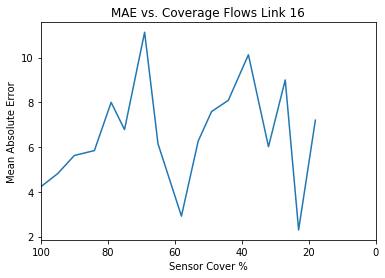

In [9]:
#run this after cell above finishes training 
plt.plot(sensors_covered, maximum_MAE)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Link 16")
plt.xlim([100, 0])
#plt.savefig('/Users/alexellard/Downloads/Link16FlowsMax.png')
plt.show()

In [9]:
maximum_MAE

[27.03572745055103,
 28.111820854160047,
 57.03511939901222,
 57.562455410597,
 56.64349024660162,
 76.79984867612376,
 76.7034306865405,
 33.43096287122796,
 32.86449056829004,
 68.52898138021773,
 61.41646409155878,
 86.12109149545589,
 85.57921022734982,
 30.675566444132883,
 94.00438958434454,
 90.49009563112445,
 94.15266963096067]

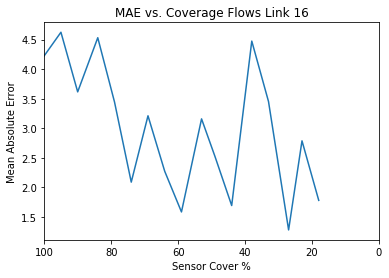

In [5]:
#run this after cell above finishes training 
plt.plot(sensors_covered, MAE_average)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Link 16")
plt.xlim([100, 0])
#plt.savefig('/Users/alexellard/Downloads/Link16FlowsMax.png')
plt.show()